# Model Time Series for COVID

## import

In [1]:
%matplotlib inline

# figure lib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# data useful lib
import pandas as pd
import numpy as np

# helper lib
import shutil
import os, stat
import re
import datetime
import math

# read json from http
import json
import urllib.request

# read csv from http
import io
import requests

# model lib
import tensorflow as tf
from sklearn.metrics import mean_absolute_error


## Definitions

In [2]:
PATH_TO_SAVE_DATA = "."
PATH_DF_POS_FR = PATH_TO_SAVE_DATA + '/' + 'df_pos_fr.csv'
PATH_DF_TEST_FR = PATH_TO_SAVE_DATA + '/' + 'df_test_fr.csv'
PATH_JSON_METEO_FR = PATH_TO_SAVE_DATA + '/' + 'data_meteo_fr.json'
PATH_DF_FEAT_FR = PATH_TO_SAVE_DATA + '/' + 'df_feat_fr.csv' 
PATH_GEO_DEP_FR = PATH_TO_SAVE_DATA + '/sources/geofrance/' + 'departments.csv'
PATH_MDL_SINGLE_STEP = PATH_TO_SAVE_DATA + '/' + "mdl_single_step_pos_fr"
PATH_MDL_MULTI_STEP = PATH_TO_SAVE_DATA + '/' + "mdl_multi_step_pos_fr"
PATH_MDL_MULTI_TFLITE = PATH_TO_SAVE_DATA + '/' + \
    'serverless/tensorflow-lite-on-aws-lambda'
PATH_MDL_MULTI_TFLITE_FILE = PATH_MDL_MULTI_TFLITE + '/' + \
    "converted_model.tflite"
PATH_SERVERLESS = PATH_MDL_MULTI_TFLITE + '/' + 'serverless.yml'

date_format = "%Y-%m-%d"

#NB_POS_DATE_MIN_DF_FEAT = 140734 # on 13/05/2020
NB_POS_DATE_MIN_DF_FEAT = 140227 # on 12/05/2020



URL_PREDICT = 'https://yl0910jrga.execute-api.us-east-2.amazonaws.com/dev/infer'

# model 
PAST_HISTORY = 14 # days used to predict next values in future
FUTURE_TARGET = 7 # nb predict days later
STEP = 1

# plot
NB_DAY_PLOT = FUTURE_TARGET*9

##  Helper functions

In [3]:
# FOR MODEL
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    '''
    Create dataset for training : create each samples (timeseries data)
    '''
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

# FOR DATES
def add_days(str_date_0, nb_days_CV):
    '''
    add days to string dates
    '''
    date_format = "%Y-%m-%d"
    date_last = datetime.datetime.strptime(str_date_0, date_format)
    date_start = date_last + datetime.timedelta(days=nb_days_CV)
    str_date_start = date_start.strftime(date_format)
    return str_date_start

def generate_list_dates(str_date_0, str_date_1, date_format=None):
    if date_format is None:
        date_format = "%Y-%m-%d"
    date_0 = datetime.datetime.strptime(str_date_0, date_format)
    date_1 = datetime.datetime.strptime(str_date_1, date_format)
    delta = date_1 - date_0
    if delta.days > 0:
        return [(date_0 + \
                 datetime.timedelta(days=I)).strftime(date_format) \
               for I in range(1, delta.days+1)]
    else:
        return None

# EXTRACT DATA
def extract_data_world(df_world_melt, df_death_melt, str_filter, str_value):
    '''
    Extract data cases & death for one country by date from df_world_melt
    
    '''

    df_cases = df_world_melt[df_world_melt[str_filter] == str_value]
    

    s_cases = df_cases.groupby("date")["nb_cases"].sum()
    df_cases_out = pd.DataFrame(columns=["date", "nb_cases"])
    df_cases_out["nb_cases"] = s_cases.values
    df_cases_out["date"] = s_cases.index
    
    if df_death_melt is not None:
        df_death = df_death_melt[df_death_melt[str_filter] == str_value]
        s_death = df_death.groupby("date")["nb_death"].sum()
        df_death_out = pd.DataFrame(columns=["date", "nb_death"])
        df_death_out["nb_death"] = s_death.values
        df_death_out["date"] = s_death.index
        return df_cases_out, df_death_out 
    else:
        print("one output ...")
        return df_cases_out 

# For Training plots
def create_time_steps(length):
    '''
    create time steps
    '''
    return list(range(-length, 0))

def plot_train_history(history, title):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
    
# save file before update
def clean_file(path_file_name):
    '''
    Clean file already traited : rename file with date
    '''
    try:
        d = datetime.datetime.now()
        str_date = '_' + d.strftime("%Y%m%d_%H_%M_%S")
       
        res_re = re.search('\.\w+$', path_file_name)
        
        path_file_name_saved = \
            path_file_name[0:res_re.start()] + str_date + res_re.group(0)
         
        shutil.move(path_file_name, path_file_name_saved) 
        print('File {} moved!'.format(path_file_name_saved))
    except:
        print('File {} does not exist!'.format(path_file_name))

## Retrieve data

In [4]:
# load dep
#df_dep_fr = pd.read_csv(PATH_GEO_DEP_FR)
##############################
# GOUV FR : UPDATE DATA 
#
# New source : "https://www.data.gouv.fr/fr/datasets/r/406c6a23-e283-4300-9484-54e78c8ae675"
# https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-resultats-des-tests-virologiques-covid-19/#_
URL_CSV_GOUV_FR = \
    'https://www.data.gouv.fr/fr/datasets/r/406c6a23-e283-4300-9484-54e78c8ae675'

# patch 29/07/2020 : SSL error patch
req = requests.get(URL_CSV_GOUV_FR).content
df_gouv_fr_raw = pd.read_csv(io.StringIO(req.decode('utf-8')), sep=";")
#df_gouv_fr_raw = df_gouv_fr_raw_0.copy()
# past treat data upper cases -> lower cases
if "t" not in df_gouv_fr_raw.columns:
    df_gouv_fr_raw["t"] =  df_gouv_fr_raw["T"]
if "p" not in df_gouv_fr_raw.columns:
    df_gouv_fr_raw["p"] =  df_gouv_fr_raw["P"]
# patch : clear data in double !!!
df_gouv_fr_raw = df_gouv_fr_raw[df_gouv_fr_raw["cl_age90"] != 0]

# creation of table data : 't':tested 'p':positive
# data =  f(line : date, dep / col: t) => f(line : date / col: dep = f(t)) 
pt_fr_test = pd.pivot_table(df_gouv_fr_raw, values=['t', 'p'], 
                            index=["jour"],
                    columns=["dep"], aggfunc=np.sum) 
pt_fr_test["date"] = pt_fr_test.index


# age (new feature)
# date / dep age pos test
# =>  date / pos mean(age) 
df_gouv_fr_raw_0 = df_gouv_fr_raw.copy()
df_gouv_fr_raw_0["prod_p_age"] = \
    df_gouv_fr_raw_0["p"] * df_gouv_fr_raw_0["cl_age90"]
df_gouv_fr_raw_0["prod_t_age"] = \
    df_gouv_fr_raw_0["t"] * df_gouv_fr_raw_0["cl_age90"]
ser_p_age = df_gouv_fr_raw_0.groupby("jour") \
    ["prod_p_age"].sum() / df_gouv_fr_raw_0.groupby("jour")["p"].sum()
df_age = pd.DataFrame(index=ser_p_age.index, columns=["pos_mean_age"], 
                      data=ser_p_age.values)
ser_t_age = df_gouv_fr_raw_0.groupby("jour") \
    ["prod_t_age"].sum() / df_gouv_fr_raw_0.groupby("jour")["t"].sum()
df_age["test_mean_age"] = ser_t_age

# prepare data positive
df_pos_fr = pt_fr_test["p"].copy()
df_pos_fr.index = pt_fr_test["date"].index
df_pos_fr["date"] = df_pos_fr.index
df_pos_fr["age"] = df_age["pos_mean_age"].copy()
# save data pos
df_pos_fr.to_csv(PATH_DF_POS_FR, index=False)

# prepare data tested
df_test_fr = pt_fr_test["t"].copy()
df_test_fr.index = pt_fr_test["date"].index
df_test_fr["date"] = df_test_fr.index
df_test_fr["age"] = df_age["test_mean_age"].copy()
# save data tested
df_test_fr.to_csv(PATH_DF_TEST_FR, index=False)


In [5]:
df_gouv_fr_raw

,dep,jour,P,T,cl_age90,t,p
0,01,2020-05-13,0,16,9,16,0
1,01,2020-05-13,1,17,19,17,1
2,01,2020-05-13,0,33,29,33,0
3,01,2020-05-13,1,72,39,72,1
4,01,2020-05-13,0,54,49,54,0
...,...,...,...,...,...,...,...
122402,978,2020-08-27,2,24,59,24,2
122403,978,2020-08-27,1,8,69,8,1
122404,978,2020-08-27,1,3,79,3,1
122405,978,2020-08-27,0,0,89,0,0


In [6]:
df_pos_fr

dep,01,02,03,04,05,06,07,08,09,10,...,971,972,973,974,975,976,977,978,date,age
jour,,,,,,,,,,,,,,,,,,,,,
2020-05-13,9,14,0,1,0,19,4,6,1,3,...,0,4,0,1,0,9,0,0,2020-05-13,60.987528
2020-05-14,9,14,2,2,7,24,4,2,0,0,...,0,4,0,1,0,9,0,0,2020-05-14,60.457610
2020-05-15,5,11,2,1,0,20,5,5,1,5,...,0,0,0,1,0,12,0,0,2020-05-15,59.810680
2020-05-16,0,7,2,0,0,2,0,1,0,0,...,0,1,0,1,0,0,0,0,2020-05-16,60.158076
2020-05-17,0,2,1,0,0,2,0,0,0,0,...,0,0,0,3,0,0,0,0,2020-05-17,61.568345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-23,2,1,0,1,0,11,0,0,2,0,...,12,0,6,16,0,6,0,2,2020-08-23,40.429530
2020-08-24,54,9,8,25,7,289,13,6,10,13,...,108,22,33,86,0,15,3,7,2020-08-24,39.931148
2020-08-25,36,10,9,16,5,245,14,6,6,11,...,48,23,30,72,1,13,0,9,2020-08-25,39.625040


In [7]:
df_test_fr

dep,01,02,03,04,05,06,07,08,09,10,...,971,972,973,974,975,976,977,978,date,age
jour,,,,,,,,,,,,,,,,,,,,,
2020-05-13,333,295,163,99,28,824,64,100,52,223,...,26,84,2,355,0,24,0,1,2020-05-13,55.423478
2020-05-14,438,524,147,117,66,755,134,108,68,191,...,74,197,2,248,0,34,0,2,2020-05-14,54.795298
2020-05-15,450,331,171,93,32,1105,143,120,48,258,...,79,147,4,519,1,44,0,5,2020-05-15,54.306721
2020-05-16,146,141,77,30,9,270,41,54,30,33,...,10,17,2,311,0,3,0,47,2020-05-16,54.355924
2020-05-17,32,56,39,18,15,121,21,27,5,10,...,4,7,3,199,0,4,0,0,2020-05-17,58.096702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-23,83,41,43,25,24,274,44,43,12,57,...,168,68,87,423,0,101,10,7,2020-08-23,46.070745
2020-08-24,1209,453,414,397,227,4442,468,411,376,623,...,1302,1031,732,3465,2,348,36,86,2020-08-24,46.242226
2020-08-25,1015,404,446,411,180,3799,406,481,241,754,...,802,854,501,2934,3,334,26,61,2020-08-25,46.254201


In [8]:
def create_url_meteo_date(str_date):
    # str_date = 2020-05-10
    num_records_max = 10000
    return 'https://public.opendatasoft.com/api/records/1.0/search/' + \
        f'?dataset=donnees-synop-essentielles-omm&q=&rows={num_records_max}' + \
        f'&sort=date&refine.date={str_date}'

def get_data_meteo_by_date(str_date):
    '''
    get data meteo for 1 day on date str_date 
    
    example : get_data_meteo_by_date("2020-01-24")
    '''
    # download raw json object
    url = create_url_meteo_date(str_date)
    data = urllib.request.urlopen(url).read().decode()
    # parse json object
    return json.loads(data)

def get_data_meteo_by_list(list_date):
    '''
    Retrieve data meteo for a list of dates
    '''
    for I, date_curr in enumerate(list_date):
        
        data_curr = get_data_meteo_by_date(date_curr)
        
        if I:
            data_out["records"] = data_out["records"] + data_curr["records"]
        else:
            data_out = data_curr.copy()
            
    return data_out
    

def create_url_meteo(num_records, num_start=0):
    # https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm  
    return 'https://public.opendatasoft.com/api/records/1.0/search/' + \
        f'?dataset=donnees-synop-essentielles-omm&q=&rows={num_records}' + \
        f'&sort=date&start={num_start}'

def get_data_meteo(num_records, num_start=0):
    # num_records max = 10000
    # download raw json object
    url = create_url_meteo(num_records, num_start)
    data = urllib.request.urlopen(url).read().decode()
    # parse json object
    return json.loads(data)
def days_between(str_date_0, str_date_1):
    '''
    calculate days between 2 string dates
    '''
    date_format = "%Y-%m-%d"
    
    date_0 = datetime.datetime.strptime(str_date_0, date_format)
    date_1 = datetime.datetime.strptime(str_date_1, date_format)
    delta = date_1 - date_0
    '''date_start = date_last + datetime.timedelta(days=nb_days_CV)
    str_date_start = date_start.strftime(date_format)
    return str_date_start'''
    return delta

# function about data meteo from json 
def get_data_meteo_date_list(data): 
    return np.unique([data["records"][I]["fields"]["date"][0:10] \
                for I in range(len(data["records"]))]).tolist()
def get_data_meteo_date_min(data):
    list_date = get_data_meteo_date_list(data)
    return min(list_date)[0:10]
def get_data_meteo_date_max(data):
    list_date = get_data_meteo_date_list(data)
    return max(list_date)[0:10]

#days_between(df_pos_fr.date.min(), )

In [9]:
# first time : 
if os.path.isfile(PATH_JSON_METEO_FR):
    f_reload_from_start = False
    f_load_missing = False
    # load
    with open(PATH_JSON_METEO_FR) as f:
        data_meteo = json.load(f)
    # check start date
    date_meteo_start = get_data_meteo_date_min(data_meteo)
    delta_days = days_between(df_pos_fr.date.min(), date_meteo_start)
    if delta_days.days > 0:
        print(f"Must reload from start, {delta_days.days} days missing")
        f_reload_from_start = True
    # check last date
    date_meteo_end = get_data_meteo_date_max(data_meteo)
    delta_days = days_between(date_meteo_end, df_pos_fr.date.max())
    if delta_days.days > 0:
        print(f"Must load more last days, {delta_days.days} days missing")
        f_load_missing = True
    
    # determine list of days to download
    list_dates = None
    if f_reload_from_start:
        # all dates between [FORCED]
        list_dates = df_pos_fr["date"].tolist()
    elif f_load_missing:
        # from date
        list_dates = df_pos_fr["date"].tolist()
        # remove days already downloaded:
        list_remove = get_data_meteo_date_list(data_meteo)
        #get_data_meteo_date_list(data_meteo)
        for item_curr in  list_remove:
            try:
                list_dates.remove(item_curr)
            except:
                print(f'{item_curr} not found in dates list')
    else:
        # download NOT needed
        list_dates = None
else:
    # all dates between [FORCED]
    f_reload_from_start = True
    f_load_missing = True
    list_dates = df_pos_fr["date"].tolist()
# if download needed
if list_dates is not None:
    data_meteo_new = get_data_meteo_by_list(list_dates)
    print(f'{len(data_meteo_new["records"])} records downloaded')
    
    if f_reload_from_start:
        # reload all
        data_meteo = data_meteo_new
    else:
        # add data
        data_meteo["records"] = data_meteo["records"] + \
            data_meteo_new["records"]      
    # save
    with open(PATH_JSON_METEO_FR, 'w') as outfile:
        json.dump(data_meteo, outfile)
else:
    print("Data meteo OK")


Data meteo OK


In [10]:
def get_rec_by_date(data_meteo, date_str):
    '''
    get one date data 
    '''
    
    # date_str = '2020-05-14'
    list_rec = []
    for rec_curr in data_meteo["records"]:
        if rec_curr['fields']["date"][0:10] == date_str:
            list_rec.append(rec_curr)
    data_out = data_meteo.copy()
    data_out["records"] = list_rec
    return data_out

def select_rec_by_station(data_meteo):
    '''
    Select list of list of data by station
    '''
    list_station = [data_meteo["records"][I]['fields']['numer_sta'] \
                    for I in range(len(data_meteo["records"]))]
    list_station = np.unique(list_station).tolist()
    
    list_rec = []
    for sta_curr in list_station:
        list_rec_curr = []
        for rec_curr in data_meteo["records"]:
            if rec_curr['fields']['numer_sta'] == sta_curr:
                list_rec_curr.append(rec_curr)
        list_rec.append(list_rec_curr)
            
    return list_rec


def get_field_in_list(list_rec, field_name):
    '''
    get a field from a list of list of data 
    '''
    list_field = []
    for I in range(len(list_rec)):
        list_field_curr = []
        for J in range(len(list_rec[I])):
            try:
                list_field_curr.append(list_rec[I][J]["fields"][field_name])
            except:
                continue
        if list_field_curr != []:
            list_field.append(list_field_curr)
    return list_field

def calculate_mean_field(list_field, fun):
    """
    calculate mean with fun on list of data
    """
    list_by_sta = []
    for list_curr in list_field:
        list_by_sta.append(fun(list_curr))

    return np.mean(list_by_sta)

def calc_list_mean_field(data_meteo, fieldname, fun):
    list_date = get_data_meteo_date_list(data_meteo)
    list_mean = []
    for date_curr in list_date:
        data_out = get_rec_by_date(data_meteo, date_curr)
        list_by_sta = select_rec_by_station(data_out)
        list_field = get_field_in_list(list_by_sta, fieldname)
        list_mean.append(calculate_mean_field(list_field, fun))
    return list_mean

In [11]:
# create features for model

# add meteo data

list_t_min = calc_list_mean_field(data_meteo, "t", min)
list_t_max = calc_list_mean_field(data_meteo, "t", max)
list_u_min = calc_list_mean_field(data_meteo, "u", min)
list_u_max = calc_list_mean_field(data_meteo, "u", max)

dict_meteo = dict()
dict_meteo["date"] = get_data_meteo_date_list(data_meteo)
dict_meteo["t_min"] = list_t_min
dict_meteo["t_max"] = list_t_max
dict_meteo["u_min"] = list_u_min
dict_meteo["u_max"] = list_u_max

df_feat_fr = pd.DataFrame(data=dict_meteo)
df_feat_fr.columns = ["date", "T_min", "T_max", "H_min", "H_max"]
df_feat_fr.sort_values(by="date", inplace=True)
df_feat_fr.index = df_feat_fr["date"]

# add positive cases
df_pos_fr["pos"] = 0
list_dep = []
for col_curr in df_pos_fr.columns:
    if re.search("^\d", col_curr):
        list_dep.append(col_curr)

for dep_curr in list_dep:
    df_pos_fr["pos"] += df_pos_fr[dep_curr]

df_feat_fr["pos"] = df_pos_fr["pos"].copy()
df_feat_fr["age_pos"] = df_pos_fr["age"].copy()

# add tested cases
df_test_fr["test"] = 0
list_dep = []
for col_curr in df_test_fr.columns:
    if re.search("^\d", col_curr):
        list_dep.append(col_curr)

for dep_curr in list_dep:
    df_test_fr["test"] += df_test_fr[dep_curr]
    
df_feat_fr["test"] = df_test_fr["test"].copy()
df_feat_fr["age_test"] = df_test_fr["age"].copy()
# add num days
df_feat_fr['day_num'] = \
    df_feat_fr["date"].astype(np.datetime64).dt.strftime("%w")

# add nb_cases
arr_nb_cases = df_feat_fr["pos"].cumsum().values
df_feat_fr["nb_cases"] = NB_POS_DATE_MIN_DF_FEAT + arr_nb_cases

In [12]:
df_feat_fr

,date,T_min,T_max,H_min,H_max,pos,age_pos,test,age_test,day_num,nb_cases
date,,,,,,,,,,,
2020-05-13,2020-05-13,284.926667,290.505000,64.661017,88.135593,882,60.987528,38904,55.423478,3,141109
2020-05-14,2020-05-14,285.050000,290.963333,59.406780,84.847458,979,60.457610,41680,54.795298,4,142088
2020-05-15,2020-05-15,285.308333,291.920000,57.372881,82.966102,1030,59.810680,47134,54.306721,5,143118
2020-05-16,2020-05-16,284.956667,293.500000,53.741379,86.534483,291,60.158076,16172,54.355924,6,143409
2020-05-17,2020-05-17,285.598333,294.446667,49.879310,85.500000,139,61.568345,6277,58.096702,0,143548
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-23,2020-08-23,290.191667,296.646667,52.758621,83.896552,894,40.429530,18404,46.070745,0,247269
2020-08-24,2020-08-24,288.921667,296.960000,51.491525,84.559322,6710,39.931148,155908,46.242226,1,253979
2020-08-25,2020-08-25,288.920000,298.748333,51.101695,85.220339,6238,39.625040,144712,46.254201,2,260217


### save

In [13]:
# save 
clean_file(PATH_DF_FEAT_FR)
df_feat_fr.to_csv(PATH_DF_FEAT_FR, index=False)

File ./df_feat_fr_20200831_18_00_26.csv moved!


## Train/Test split

In [5]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

df_feat_fr

,date,T_min,T_max,H_min,H_max,pos,age_pos,test,age_test,day_num,nb_cases
date,,,,,,,,,,,
2020-05-13,2020-05-13,284.926667,290.505000,64.661017,88.135593,882,60.987528,38904,55.423478,3,141109
2020-05-14,2020-05-14,285.050000,290.963333,59.406780,84.847458,979,60.457610,41680,54.795298,4,142088
2020-05-15,2020-05-15,285.308333,291.920000,57.372881,82.966102,1030,59.810680,47134,54.306721,5,143118
2020-05-16,2020-05-16,284.956667,293.500000,53.741379,86.534483,291,60.158076,16172,54.355924,6,143409
2020-05-17,2020-05-17,285.598333,294.446667,49.879310,85.500000,139,61.568345,6277,58.096702,0,143548
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-23,2020-08-23,290.191667,296.646667,52.758621,83.896552,894,40.429530,18404,46.070745,0,247269
2020-08-24,2020-08-24,288.921667,296.960000,51.491525,84.559322,6710,39.931148,155908,46.242226,1,253979
2020-08-25,2020-08-25,288.920000,298.748333,51.101695,85.220339,6238,39.625040,144712,46.254201,2,260217


In [6]:
# keep 25 Validation samples:
TRAIN_SPLIT = df_feat_fr.shape[0] - (2 * FUTURE_TARGET)
#TRAIN_SPLIT = 45
print(f"TRAIN_SPLIT = {TRAIN_SPLIT}")

TRAIN_SPLIT = 93


## Exploration

In [97]:
df_feat_fr["train"] = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat_fr.shape[0])]
df_feat_fr

,date,T_min,T_max,H_min,H_max,pos,age_pos,test,age_test,day_num,nb_cases,train
date,,,,,,,,,,,,
2020-05-13,2020-05-13,284.926667,290.505000,64.661017,88.135593,882,60.987528,38904,55.423478,3,141109,True
2020-05-14,2020-05-14,285.050000,290.963333,59.406780,84.847458,979,60.457610,41680,54.795298,4,142088,True
2020-05-15,2020-05-15,285.308333,291.920000,57.372881,82.966102,1030,59.810680,47134,54.306721,5,143118,True
2020-05-16,2020-05-16,284.956667,293.500000,53.741379,86.534483,291,60.158076,16172,54.355924,6,143409,True
2020-05-17,2020-05-17,285.598333,294.446667,49.879310,85.500000,139,61.568345,6277,58.096702,0,143548,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-23,2020-08-23,290.191667,296.646667,52.758621,83.896552,894,40.429530,18404,46.070745,0,247269,False
2020-08-24,2020-08-24,288.921667,296.960000,51.491525,84.559322,6710,39.931148,155908,46.242226,1,253979,False
2020-08-25,2020-08-25,288.920000,298.748333,51.101695,85.220339,6238,39.625040,144712,46.254201,2,260217,False


In [98]:
df_feat_fr[df_feat_fr["train"] == True]["date"].max()

'2020-08-14'

Distribution of TRAIN / VALIDATION dataset :

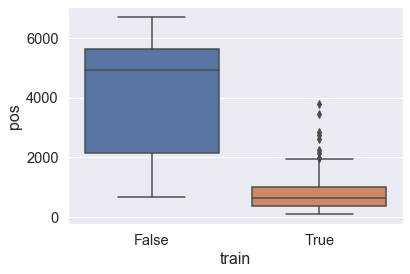

In [99]:
ax = sns.boxplot(x="train", y="pos", data=df_feat_fr)

### age

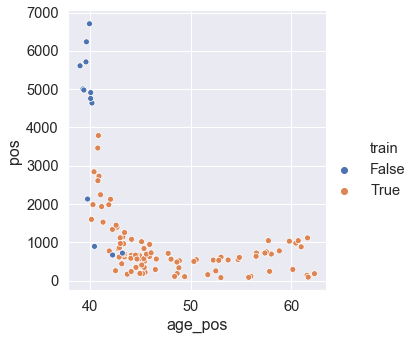

In [100]:
sns.relplot(x="age_pos", y="pos", hue="train", data=df_feat_fr);

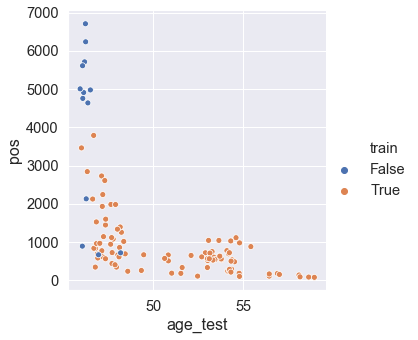

In [101]:
sns.relplot(x="age_test", y="pos", hue="train", data=df_feat_fr);

### Impact of day 

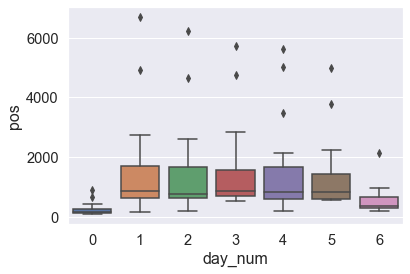

In [102]:
ax = sns.boxplot(x="day_num", y="pos", data=df_feat_fr)

=> It is not the reality. On weekend, a lot of local medical structures don't trace positive cases.

### Temperature impact

In [103]:
df_feat_fr["T_mean"] = 0.5 * (df_feat_fr["T_min"] + df_feat_fr["T_max"])

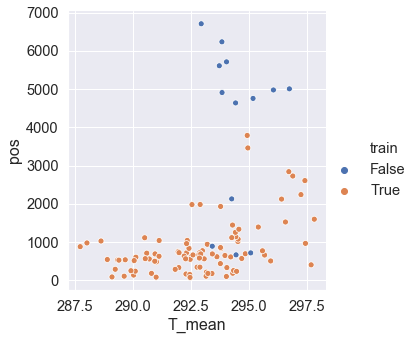

In [104]:
sns.relplot(x="T_mean", y="pos", hue="train", data=df_feat_fr);

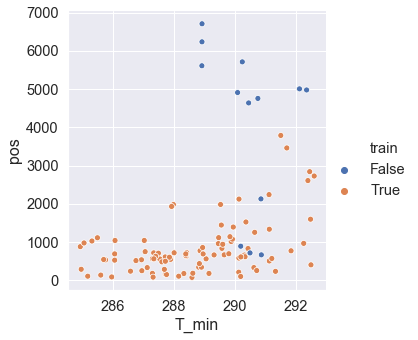

In [105]:
sns.relplot(x="T_min", y="pos", hue="train", data=df_feat_fr);

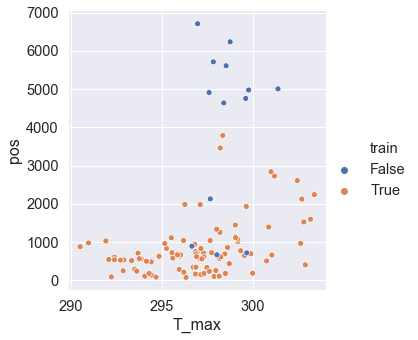

In [106]:
sns.relplot(x="T_max", y="pos", hue="train", data=df_feat_fr);

Impact of cold temperature :

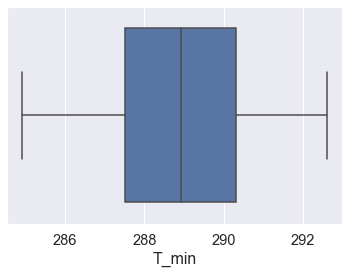

In [107]:
ax = sns.boxplot(x="T_min", data=df_feat_fr)

In [108]:
df_feat_fr["T_min"].mean()

288.92306795175534

In [109]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].mean()).value_counts()

True     54
False    53
Name: T_min, dtype: int64

In [110]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].median()).value_counts()

False    54
True     53
Name: T_min, dtype: int64

In [111]:
df_feat_fr["T_min"].median()

288.92166666666674

In [112]:
df_feat_fr["cold_min"] = df_feat_fr["T_min"] < df_feat_fr["T_min"].median()

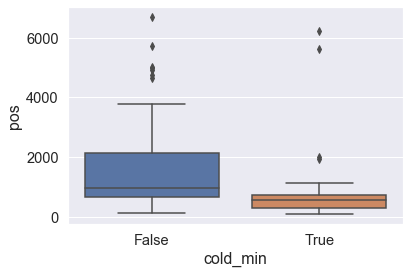

In [113]:
ax = sns.boxplot(x="cold_min", y="pos", data=df_feat_fr)

=> colder T min then less positive cases! (strange behaviour... opposite of flu ?)

Impact of T mean : 

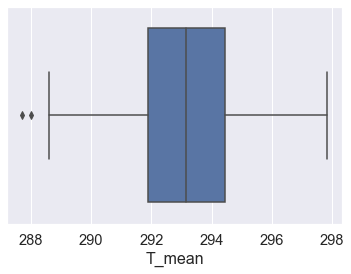

In [114]:
ax = sns.boxplot(x="T_mean", data=df_feat_fr)

In [115]:
df_feat_fr["T_mean"].median()

293.15083333333337

In [116]:
df_feat_fr["cold_mean"] = df_feat_fr["T_mean"] < df_feat_fr["T_mean"].median()

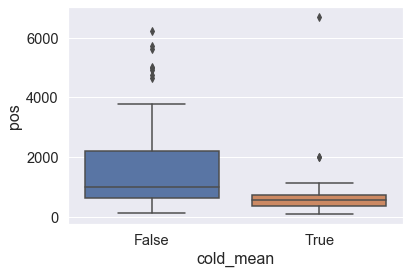

In [117]:
ax = sns.boxplot(x="cold_mean", y="pos", data=df_feat_fr)

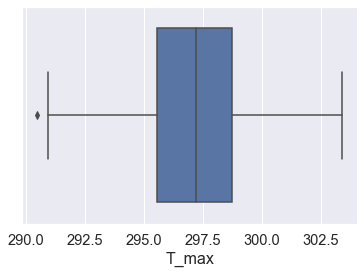

In [118]:
ax = sns.boxplot(x="T_max", data=df_feat_fr)

In [119]:
df_feat_fr["T_max"].median()

297.19666666666666

In [120]:
df_feat_fr["cold_max"] = df_feat_fr["T_max"] < df_feat_fr["T_max"].median()

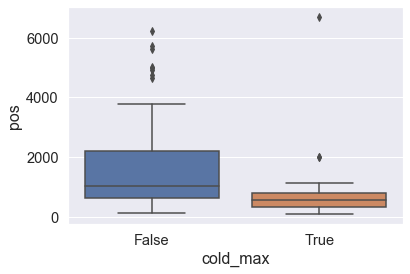

In [121]:
ax = sns.boxplot(x="cold_max", y="pos", data=df_feat_fr)

=> significant like with day_num

### Impact of Humidity

In [122]:
df_feat_fr["H_mean"] = 0.5 * (df_feat_fr["H_min"] + df_feat_fr["H_max"])

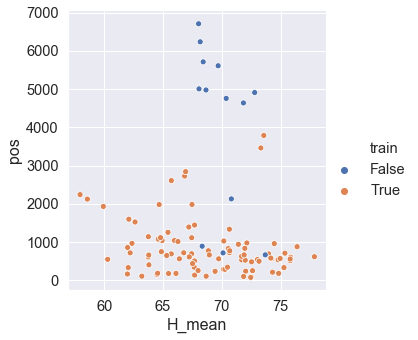

In [123]:
sns.relplot(x="H_mean", y="pos", hue="train", data=df_feat_fr);

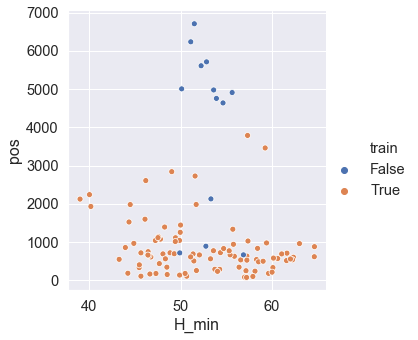

In [124]:
sns.relplot(x="H_min", y="pos", hue="train", data=df_feat_fr);

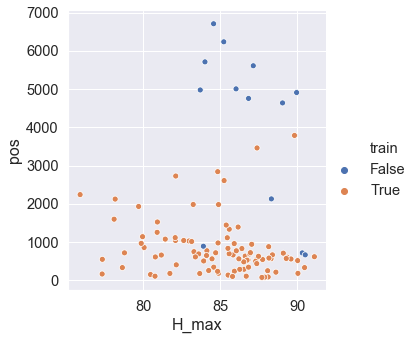

In [125]:
sns.relplot(x="H_max", y="pos", hue="train", data=df_feat_fr);

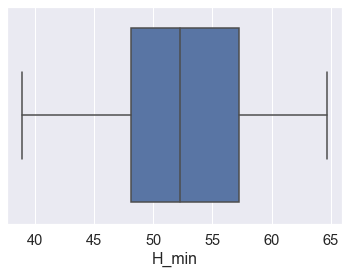

In [126]:
ax = sns.boxplot(x="H_min", data=df_feat_fr)

In [127]:
df_feat_fr["H_min"].median()

52.23728813559321

In [128]:
df_feat_fr["dry_min"] = df_feat_fr["H_min"] < df_feat_fr["H_min"].median()

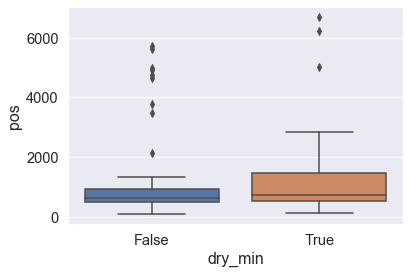

In [129]:
ax = sns.boxplot(x="dry_min", y="pos", data=df_feat_fr)

=> maybe dry more positive cases ?

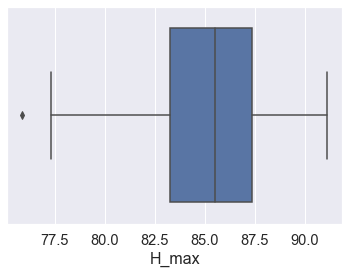

In [130]:
ax = sns.boxplot(x="H_max", data=df_feat_fr)

In [131]:
df_feat_fr["H_max"].median()

85.5

In [132]:
df_feat_fr["dry_max"] = df_feat_fr["H_max"] < df_feat_fr["H_max"].median()

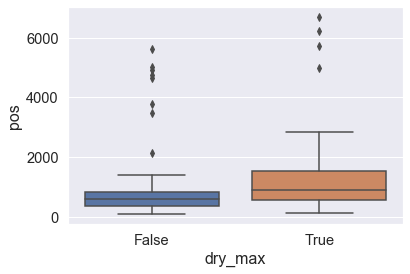

In [133]:
ax = sns.boxplot(x="dry_max", y="pos", data=df_feat_fr)

=> real impact of Hmax?

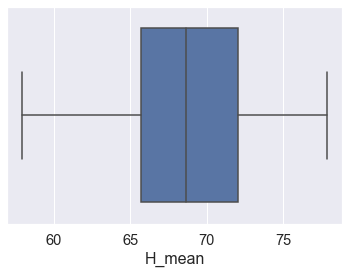

In [134]:
ax = sns.boxplot(x="H_mean", data=df_feat_fr)

In [135]:
df_feat_fr["H_mean"].median()

68.66964285714286

In [136]:
df_feat_fr["dry_mean"] = df_feat_fr["H_mean"] < df_feat_fr["H_mean"].median()

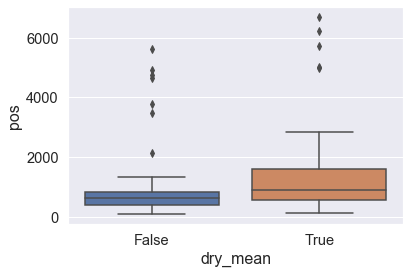

In [137]:
ax = sns.boxplot(x="dry_mean", y="pos", data=df_feat_fr)

=> Same maybe impact of humidity H_max => dryer then more positive cases ?

### Seasonality impact

In [138]:
df_feat_fr["month"] = df_feat_fr["date"].astype(np.datetime64).dt.month

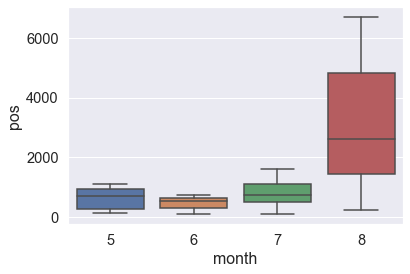

In [139]:
ax = sns.boxplot(x="month", y="pos", data=df_feat_fr)

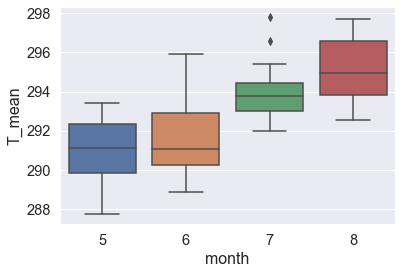

In [140]:
ax = sns.boxplot(x="month", y="T_mean", data=df_feat_fr)

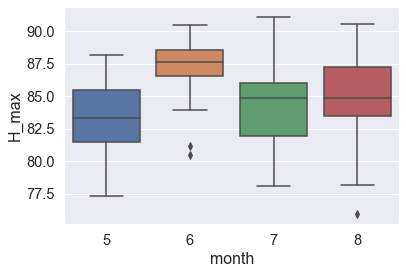

In [141]:
ax = sns.boxplot(x="month", y="H_max", data=df_feat_fr)

In [142]:
pt_month = df_feat_fr.pivot_table(values=["pos"],
                           index="month", aggfunc=np.sum)
pt_month

,pos
month,
5,11662
6,14090
7,24490
8,81074


### Nb Tested

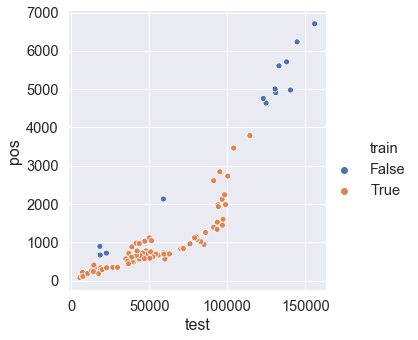

In [143]:
sns.relplot(x="test", y="pos", hue="train", data=df_feat_fr);

In [144]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested"))
# Edit the layout
fig.update_layout(title='COVID-19 Tested  (France)',
                   yaxis_title='nb Tested')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

In [145]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=100*df_feat_fr["pos"] / df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate"))
# Edit the layout
fig.update_layout(title='COVID-19 Positive rate  (France)',
                   yaxis_title='pos. rate [%]')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

## Prepare features

In [146]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

In [7]:
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
features

,T_min,T_max,H_min,H_max,pos,test,day_num,age_pos,age_test
date,,,,,,,,,
2020-05-13,284.926667,290.505000,64.661017,88.135593,882,38904,3,60.987528,55.423478
2020-05-14,285.050000,290.963333,59.406780,84.847458,979,41680,4,60.457610,54.795298
2020-05-15,285.308333,291.920000,57.372881,82.966102,1030,47134,5,59.810680,54.306721
2020-05-16,284.956667,293.500000,53.741379,86.534483,291,16172,6,60.158076,54.355924
2020-05-17,285.598333,294.446667,49.879310,85.500000,139,6277,0,61.568345,58.096702
...,...,...,...,...,...,...,...,...,...
2020-08-23,290.191667,296.646667,52.758621,83.896552,894,18404,0,40.429530,46.070745
2020-08-24,288.921667,296.960000,51.491525,84.559322,6710,155908,1,39.931148,46.242226
2020-08-25,288.920000,298.748333,51.101695,85.220339,6238,144712,2,39.625040,46.254201


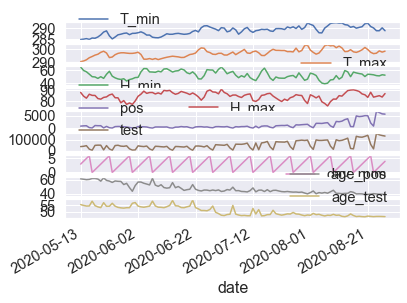

In [148]:
features.plot(subplots=True);

In [149]:
#TRAIN_SPLIT = 45

In [8]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [9]:
dataset = (dataset-data_mean)/data_std

## Single step model

Use past_history samples to predict in future forward STEP times

In [152]:
#(dataset, target, start_index, end_index, history_size,
#                      target_size, step, single_step=False)

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 4], 
                                                0, TRAIN_SPLIT, PAST_HISTORY,
                                                FUTURE_TARGET, STEP,
                                                single_step=True)

x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 4],
                                TRAIN_SPLIT-PAST_HISTORY, None, PAST_HISTORY,
                                FUTURE_TARGET, STEP,
                                single_step=True)

In [153]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (14, 9)


In [156]:
 x_train_single.shape[0]

79

In [154]:
BATCH_SIZE = x_train_single.shape[0]
BATCH_SIZE_VAL = y_val_single.shape[0]
BUFFER_SIZE = TRAIN_SPLIT
tf.random.set_seed(0)

In [155]:
 y_val_single.shape[0]

7

In [157]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, 
                                                        y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE). \
    batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, 
                                                      y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE_VAL).repeat()


In [158]:
data_test = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
data_test = data_test.cache().shuffle(BUFFER_SIZE). \
    batch(BATCH_SIZE).repeat(2)
list_test = list(data_test.as_numpy_iterator())
print(len(list_test))
print(len(list_test[0]))
print(list_test[0][0].shape)
print(list_test[0][1].shape)

2
2
(79, 14, 9)
(79,)


In [159]:
train_data_single.take(31)

<TakeDataset shapes: ((None, 14, 9), (None,)), types: (tf.float64, tf.float64)>

In [160]:
x_train_single.shape

(79, 14, 9)

In [161]:
x_train_single.shape[-2:]

(14, 9)

In [162]:
train_data_single

<RepeatDataset shapes: ((None, 14, 9), (None,)), types: (tf.float64, tf.float64)>

In [163]:
val_data_single

<RepeatDataset shapes: ((None, 14, 9), (None,)), types: (tf.float64, tf.float64)>

In [164]:
x_train_single.shape[-2:]

(14, 9)

In [165]:
'''for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)'''

'for x, y in val_data_single.take(1):\n    print(single_step_model.predict(x).shape)'

In [167]:
features.shape[1]

9


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00605: early stopping
Run #0 : val_loss = 2.524973453113724


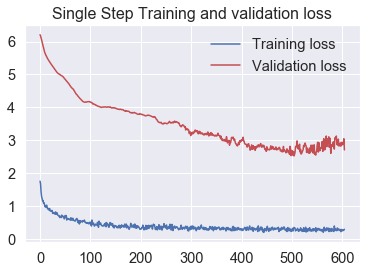

INFO:tensorflow:Assets written to: ./mdl_single_step_pos_fr\assets

 Run #1
Run #1 : val_loss = 2.2358210522795043


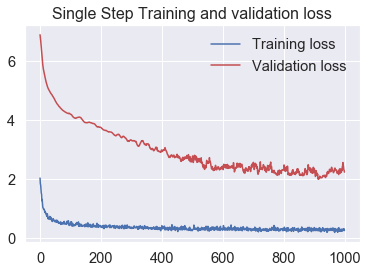

INFO:tensorflow:Assets written to: ./mdl_single_step_pos_fr\assets

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 00806: early stopping
Run #2 : val_loss = 3.058806292670827

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 00637: early stopping
Run #3 : val_loss = 1.7260173310436109


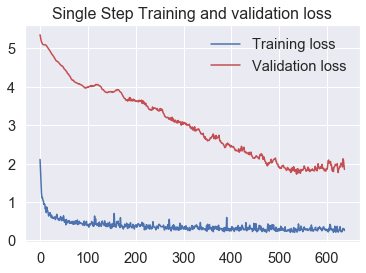

INFO:tensorflow:Assets written to: ./mdl_single_step_pos_fr\assets

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 00919: early stopping
Run #4 : val_loss = 2.0463231045866332

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 00731: early stopping
Run #5 : val_loss = 2.3233858612612637

 Run #6
Restoring model weights from the end of the best epoch.
Epoch 00632: early stopping
Run #6 : val_loss = 2.2280437019900234

 Run #7
Restoring model weights from the end of the best epoch.
Epoch 00736: early stopping
Run #7 : val_loss = 1.8416109415322357

 Run #8
Restoring model weights from the end of the best epoch.
Epoch 00598: early stopping
Run #8 : val_loss = 2.688285496576205

 Run #9
Restoring model weights from the end of the best epoch.
Epoch 00910: early stopping
Run #9 : val_loss = 1.8911744448000631
Wall time: 2min 42s


In [173]:
%%time
NB_TRY = 10
EVALUATION_INTERVAL = 1
EPOCHS = 1000
patience = 100
# Hyper-parameters
# lr = 1e-2 val_loss = 1.6623600816733817 (without dropout, patience 30 epoch 400 NB TRY 10)
lr = 1e-2
decay = 1e-6
momentum = 0.9
nesterov = True 


sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                          nesterov=nesterov) 

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                   verbose=1, patience=patience,
                                   restore_best_weights=True)


list_loss = []

for I in range(NB_TRY):
    print("")
    print(f" Run #{I}")
    single_step_model = tf.keras.models.Sequential()

    '''single_step_model.add(tf.keras.layers.LSTM(4, return_sequences=True,
                                            input_shape=x_train_single.shape[-2:]))

    single_step_model.add(tf.keras.layers.LSTM(2, activation='relu'))'''

    single_step_model.add(tf.keras.layers.LSTM(features.shape[1],
                                        input_shape=x_train_single.shape[-2:]))
    
    single_step_model.add(tf.keras.layers.Dropout(0.2))
    
    single_step_model.add(tf.keras.layers.BatchNormalization())

    single_step_model.add(tf.keras.layers.Dense(1))

    single_step_model.compile(optimizer=sgd_2, loss='mae')


    single_step_history = single_step_model.fit(train_data_single, 
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=1,
                                            callbacks=[es],
                                            verbose=0)

    # re- eval best epoch model
    y_val_pred = single_step_model.predict(x_val_single)
    mae_curr = mean_absolute_error(y_val_single, y_val_pred)
    if (I == 0):
        list_loss.append(mae_curr)
        
    
    # find the best model
    print(f"Run #{I} : val_loss = {mae_curr}")
    if (mae_curr < np.min(list_loss)) | (I == 0):
        # plot history
        plot_train_history(single_step_history,
                   'Single Step Training and validation loss')
        # save
        if not(os.path.isdir(PATH_MDL_SINGLE_STEP)):
            os.mkdir(PATH_MDL_SINGLE_STEP)
        single_step_model.save(PATH_MDL_SINGLE_STEP)
        
    if (I != 0):   
        list_loss.append(mae_curr)
        

In [174]:
# reload best model
single_step_model = tf.keras.models.load_model(PATH_MDL_SINGLE_STEP)

In [175]:
y_val_pred = single_step_model.predict(x_val_single)
mean_absolute_error(y_val_single, y_val_pred)

1.7260171948044227

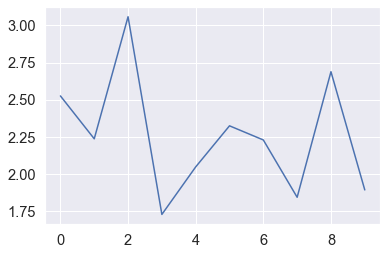

In [176]:
plt.plot(list_loss)

In [177]:
'''plot_train_history(single_step_history,
                   'Single Step Training and validation loss')'''

"plot_train_history(single_step_history,\n                   'Single Step Training and validation loss')"

In [178]:


def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [179]:
for x, y in val_data_single.take(1):
    print(x.shape)

(7, 14, 9)


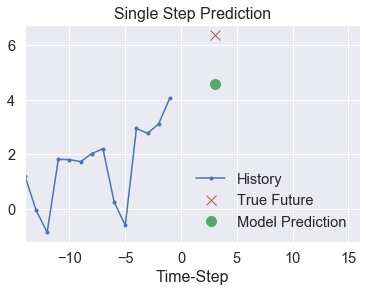

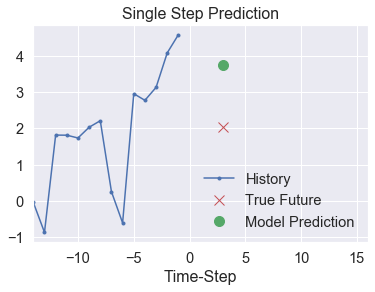

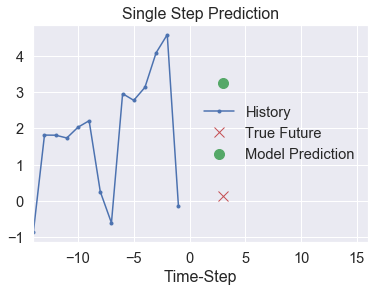

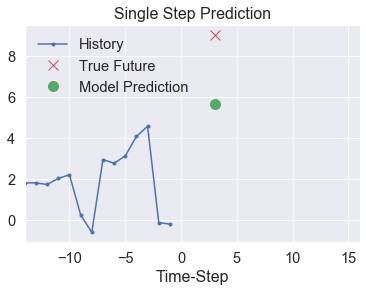

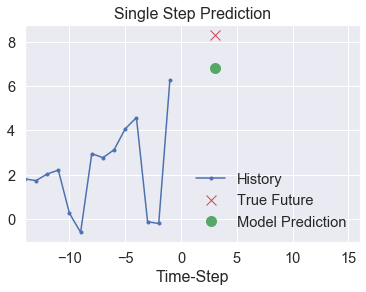

In [181]:
for x, y in val_data_single.take(1):
    for I in range(5):
        plot = show_plot([x[I][:, 4].numpy(), y[I].numpy(),
                        single_step_model.predict(x)[I]], 3,
                       'Single Step Prediction')
        plot.show()


## Multi-step model

### Helper functions

In [10]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 4]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

### data 14D_to_7D

In [11]:
TRAIN_SPLIT

93

In [54]:
dataset.shape

(107, 9)

In [12]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 
                                0, TRAIN_SPLIT, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                TRAIN_SPLIT-PAST_HISTORY, None, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

In [13]:
y_train_multi.shape

(79, 7)

In [14]:
print ('{} Single window of past history : {}'.format(x_train_multi.shape[0],
                                                      x_train_multi[0].shape))
print ('\n {} Target temperature to predict : {}'.format(y_train_multi.shape[0],
                                                        y_train_multi[0].shape))

79 Single window of past history : (14, 9)

 79 Target temperature to predict : (7,)


In [15]:
BATCH_SIZE = x_train_multi.shape[0]
BATCH_SIZE_VAL = y_val_multi.shape[0]
BUFFER_SIZE = TRAIN_SPLIT
tf.random.set_seed(0)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, 
                                                       y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE_VAL).repeat()

print("For Training : ")
print("BATCH_SIZE :", BATCH_SIZE)
print("BUFFER_SIZE :", BUFFER_SIZE)
print("\nFor validation : ")
print("BATCH_SIZE_VAL :", BATCH_SIZE_VAL)


For Training : 
BATCH_SIZE : 79
BUFFER_SIZE : 93

For validation : 
BATCH_SIZE_VAL : 7


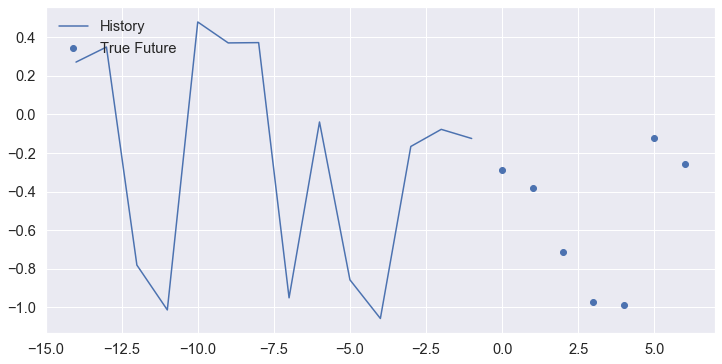

In [16]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

### Training

In [189]:
print(f"nb samples for training : {x_train_multi.shape[0]}")
print(f"nb samples for validation : {x_val_multi.shape[0]}")

nb samples for training : 79
nb samples for validation : 7



 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00878: early stopping
Run #0 : val_loss = 3.0659732818603516


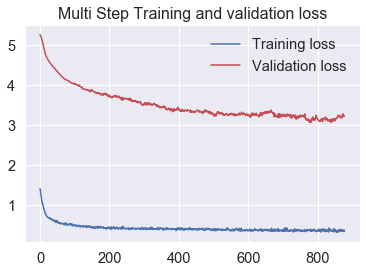

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #1
Restoring model weights from the end of the best epoch.
Epoch 01092: early stopping
Run #1 : val_loss = 2.7387855052948


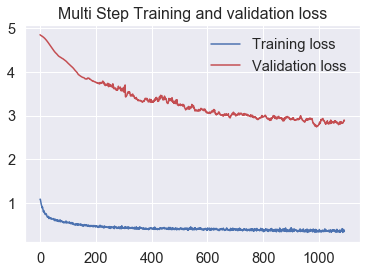

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 01375: early stopping
Run #2 : val_loss = 2.289276599884033


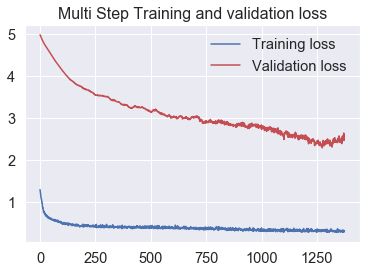

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 00672: early stopping
Run #3 : val_loss = 2.7440547943115234

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 00530: early stopping
Run #4 : val_loss = 2.846614360809326

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 00855: early stopping
Run #5 : val_loss = 2.36342453956604

 Run #6
Restoring model weights from the end of the best epoch.
Epoch 01159: early stopping
Run #6 : val_loss = 2.936699151992798

 Run #7
Restoring model weights from the end of the best epoch.
Epoch 00842: early stopping
Run #7 : val_loss = 2.9267327785491943

 Run #8
Restoring model weights from the end of the best epoch.
Epoch 00534: early stopping
Run #8 : val_loss = 3.540332078933716

 Run #9
Restoring model weights from the end of the best epoch.
Epoch 00833: early stopping
Run #9 : val_loss = 2.73490309715271

 Run #10
Restori

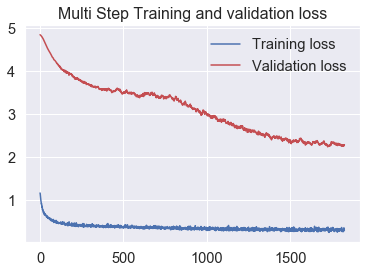

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #11
Restoring model weights from the end of the best epoch.
Epoch 01631: early stopping
Run #11 : val_loss = 1.6432383060455322


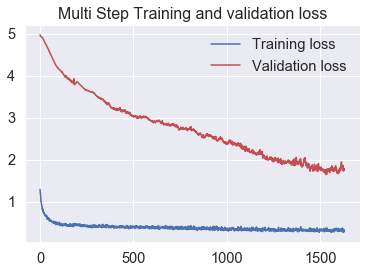

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #12
Restoring model weights from the end of the best epoch.
Epoch 01788: early stopping
Run #12 : val_loss = 2.18733811378479

 Run #13
Restoring model weights from the end of the best epoch.
Epoch 00524: early stopping
Run #13 : val_loss = 3.0752646923065186

 Run #14
Restoring model weights from the end of the best epoch.
Epoch 01916: early stopping
Run #14 : val_loss = 1.8712241649627686

 Run #15
Restoring model weights from the end of the best epoch.
Epoch 00501: early stopping
Run #15 : val_loss = 3.277621030807495

 Run #16
Restoring model weights from the end of the best epoch.
Epoch 00676: early stopping
Run #16 : val_loss = 2.936932325363159

 Run #17
Restoring model weights from the end of the best epoch.
Epoch 00793: early stopping
Run #17 : val_loss = 2.6513137817382812

 Run #18
Restoring model weights from the end of the best epoch.
Epoch 00932: early stopping
Run #18 : val_loss = 2.712315797805786



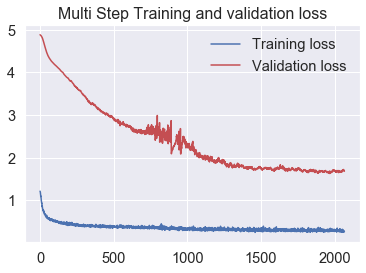

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #72
Restoring model weights from the end of the best epoch.
Epoch 00589: early stopping
Run #72 : val_loss = 3.28132700920105

 Run #73
Restoring model weights from the end of the best epoch.
Epoch 00861: early stopping
Run #73 : val_loss = 2.5894906520843506

 Run #74
Restoring model weights from the end of the best epoch.
Epoch 00600: early stopping
Run #74 : val_loss = 3.100508213043213

 Run #75
Restoring model weights from the end of the best epoch.
Epoch 00581: early stopping
Run #75 : val_loss = 2.8748247623443604

 Run #76
Restoring model weights from the end of the best epoch.
Epoch 00692: early stopping
Run #76 : val_loss = 2.868198871612549

 Run #77
Restoring model weights from the end of the best epoch.
Epoch 00822: early stopping
Run #77 : val_loss = 2.72007155418396

 Run #78
Restoring model weights from the end of the best epoch.
Epoch 01170: early stopping
Run #78 : val_loss = 2.5539512634277344

 

Restoring model weights from the end of the best epoch.
Epoch 00841: early stopping
Run #133 : val_loss = 2.699875593185425

 Run #134
Restoring model weights from the end of the best epoch.
Epoch 00942: early stopping
Run #134 : val_loss = 2.8763396739959717

 Run #135
Restoring model weights from the end of the best epoch.
Epoch 00967: early stopping
Run #135 : val_loss = 2.6009984016418457

 Run #136
Restoring model weights from the end of the best epoch.
Epoch 00785: early stopping
Run #136 : val_loss = 2.8619821071624756

 Run #137
Restoring model weights from the end of the best epoch.
Epoch 01352: early stopping
Run #137 : val_loss = 2.3379342555999756

 Run #138
Restoring model weights from the end of the best epoch.
Epoch 00674: early stopping
Run #138 : val_loss = 2.835381031036377

 Run #139
Restoring model weights from the end of the best epoch.
Epoch 00655: early stopping
Run #139 : val_loss = 3.002549409866333

 Run #140
Restoring model weights from the end of the best ep

Restoring model weights from the end of the best epoch.
Epoch 00444: early stopping
Run #194 : val_loss = 3.635197162628174

 Run #195
Restoring model weights from the end of the best epoch.
Epoch 00850: early stopping
Run #195 : val_loss = 3.13165283203125

 Run #196
Restoring model weights from the end of the best epoch.
Epoch 01581: early stopping
Run #196 : val_loss = 1.9059303998947144

 Run #197
Restoring model weights from the end of the best epoch.
Epoch 01344: early stopping
Run #197 : val_loss = 2.0351905822753906

 Run #198
Restoring model weights from the end of the best epoch.
Epoch 00443: early stopping
Run #198 : val_loss = 3.423421621322632

 Run #199
Restoring model weights from the end of the best epoch.
Epoch 00764: early stopping
Run #199 : val_loss = 2.5290141105651855

 Run #200
Restoring model weights from the end of the best epoch.
Epoch 01708: early stopping
Run #200 : val_loss = 2.3848674297332764

 Run #201
Restoring model weights from the end of the best epo

Restoring model weights from the end of the best epoch.
Epoch 01357: early stopping
Run #255 : val_loss = 2.3648791313171387

 Run #256
Restoring model weights from the end of the best epoch.
Epoch 01717: early stopping
Run #256 : val_loss = 1.9185278415679932

 Run #257
Restoring model weights from the end of the best epoch.
Epoch 01379: early stopping
Run #257 : val_loss = 2.425975799560547

 Run #258
Restoring model weights from the end of the best epoch.
Epoch 01182: early stopping
Run #258 : val_loss = 2.267014980316162

 Run #259
Restoring model weights from the end of the best epoch.
Epoch 00686: early stopping
Run #259 : val_loss = 2.844849109649658

 Run #260
Restoring model weights from the end of the best epoch.
Epoch 00989: early stopping
Run #260 : val_loss = 2.5066370964050293

 Run #261
Restoring model weights from the end of the best epoch.
Epoch 00733: early stopping
Run #261 : val_loss = 2.9597249031066895

 Run #262
Restoring model weights from the end of the best ep

Restoring model weights from the end of the best epoch.
Epoch 00617: early stopping
Run #316 : val_loss = 2.9012680053710938

 Run #317
Restoring model weights from the end of the best epoch.
Epoch 01621: early stopping
Run #317 : val_loss = 2.011110544204712

 Run #318
Restoring model weights from the end of the best epoch.
Epoch 00572: early stopping
Run #318 : val_loss = 3.364598512649536

 Run #319
Restoring model weights from the end of the best epoch.
Epoch 00658: early stopping
Run #319 : val_loss = 2.833103656768799

 Run #320
Restoring model weights from the end of the best epoch.
Epoch 00990: early stopping
Run #320 : val_loss = 2.709272623062134

 Run #321
Restoring model weights from the end of the best epoch.
Epoch 00841: early stopping
Run #321 : val_loss = 2.733090877532959

 Run #322
Restoring model weights from the end of the best epoch.
Epoch 00787: early stopping
Run #322 : val_loss = 2.671855926513672

 Run #323
Restoring model weights from the end of the best epoch

Restoring model weights from the end of the best epoch.
Epoch 00857: early stopping
Run #377 : val_loss = 2.3706517219543457

 Run #378
Restoring model weights from the end of the best epoch.
Epoch 00733: early stopping
Run #378 : val_loss = 2.784665584564209

 Run #379
Restoring model weights from the end of the best epoch.
Epoch 00624: early stopping
Run #379 : val_loss = 3.10062837600708

 Run #380
Restoring model weights from the end of the best epoch.
Epoch 00839: early stopping
Run #380 : val_loss = 2.892726182937622

 Run #381
Restoring model weights from the end of the best epoch.
Epoch 01070: early stopping
Run #381 : val_loss = 2.553776979446411

 Run #382
Restoring model weights from the end of the best epoch.
Epoch 00663: early stopping
Run #382 : val_loss = 2.825366973876953

 Run #383
Restoring model weights from the end of the best epoch.
Epoch 00655: early stopping
Run #383 : val_loss = 2.9845826625823975

 Run #384
Restoring model weights from the end of the best epoch

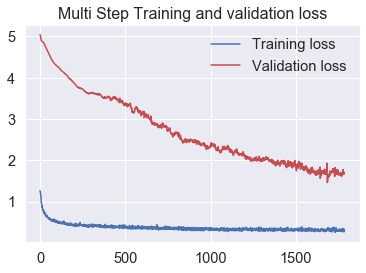

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr\assets

 Run #403
Restoring model weights from the end of the best epoch.
Epoch 01300: early stopping
Run #403 : val_loss = 1.9371463060379028

 Run #404
Restoring model weights from the end of the best epoch.
Epoch 00916: early stopping
Run #404 : val_loss = 2.6067488193511963

 Run #405
Restoring model weights from the end of the best epoch.
Epoch 00690: early stopping
Run #405 : val_loss = 3.070878744125366

 Run #406
Restoring model weights from the end of the best epoch.
Epoch 00673: early stopping
Run #406 : val_loss = 2.683056592941284

 Run #407
Restoring model weights from the end of the best epoch.
Epoch 00823: early stopping
Run #407 : val_loss = 2.4849488735198975

 Run #408
Restoring model weights from the end of the best epoch.
Epoch 00777: early stopping
Run #408 : val_loss = 2.819474935531616

 Run #409
Restoring model weights from the end of the best epoch.
Epoch 00602: early stopping
Run #409 : val_loss = 2.61

Restoring model weights from the end of the best epoch.
Epoch 00744: early stopping
Run #463 : val_loss = 3.0950355529785156

 Run #464
Restoring model weights from the end of the best epoch.
Epoch 00628: early stopping
Run #464 : val_loss = 3.107762098312378

 Run #465
Restoring model weights from the end of the best epoch.
Epoch 00754: early stopping
Run #465 : val_loss = 3.1655113697052

 Run #466
Restoring model weights from the end of the best epoch.
Epoch 01787: early stopping
Run #466 : val_loss = 1.6670743227005005

 Run #467
Restoring model weights from the end of the best epoch.
Epoch 00704: early stopping
Run #467 : val_loss = 2.603682279586792

 Run #468
Restoring model weights from the end of the best epoch.
Epoch 00761: early stopping
Run #468 : val_loss = 2.7840237617492676

 Run #469
Restoring model weights from the end of the best epoch.
Epoch 00700: early stopping
Run #469 : val_loss = 2.8128433227539062

 Run #470
Restoring model weights from the end of the best epoc

Restoring model weights from the end of the best epoch.
Epoch 00764: early stopping
Run #524 : val_loss = 2.869415283203125

 Run #525
Restoring model weights from the end of the best epoch.
Epoch 00716: early stopping
Run #525 : val_loss = 2.6084606647491455

 Run #526
Restoring model weights from the end of the best epoch.
Epoch 00546: early stopping
Run #526 : val_loss = 3.275766611099243

 Run #527
Restoring model weights from the end of the best epoch.
Epoch 00662: early stopping
Run #527 : val_loss = 3.0334560871124268

 Run #528
Restoring model weights from the end of the best epoch.
Epoch 00684: early stopping
Run #528 : val_loss = 2.8501570224761963

 Run #529
Restoring model weights from the end of the best epoch.
Epoch 01649: early stopping
Run #529 : val_loss = 2.036944627761841

 Run #530
Restoring model weights from the end of the best epoch.
Epoch 00598: early stopping
Run #530 : val_loss = 3.1964879035949707

 Run #531
Restoring model weights from the end of the best ep

Restoring model weights from the end of the best epoch.
Epoch 00994: early stopping
Run #585 : val_loss = 2.5324814319610596

 Run #586
Restoring model weights from the end of the best epoch.
Epoch 00730: early stopping
Run #586 : val_loss = 2.9102442264556885

 Run #587
Restoring model weights from the end of the best epoch.
Epoch 00543: early stopping
Run #587 : val_loss = 2.753329038619995

 Run #588
Restoring model weights from the end of the best epoch.
Epoch 00716: early stopping
Run #588 : val_loss = 3.0019242763519287

 Run #589
Restoring model weights from the end of the best epoch.
Epoch 00684: early stopping
Run #589 : val_loss = 2.9417991638183594

 Run #590
Restoring model weights from the end of the best epoch.
Epoch 01244: early stopping
Run #590 : val_loss = 2.232318162918091

 Run #591
Restoring model weights from the end of the best epoch.
Epoch 00737: early stopping
Run #591 : val_loss = 2.9213979244232178

 Run #592
Restoring model weights from the end of the best e

Restoring model weights from the end of the best epoch.
Epoch 01582: early stopping
Run #646 : val_loss = 2.3649251461029053

 Run #647
Restoring model weights from the end of the best epoch.
Epoch 00824: early stopping
Run #647 : val_loss = 2.7897284030914307

 Run #648
Restoring model weights from the end of the best epoch.
Epoch 01095: early stopping
Run #648 : val_loss = 2.6949055194854736

 Run #649
Restoring model weights from the end of the best epoch.
Epoch 00936: early stopping
Run #649 : val_loss = 2.63570237159729

 Run #650
Restoring model weights from the end of the best epoch.
Epoch 00727: early stopping
Run #650 : val_loss = 2.556800365447998

 Run #651
Restoring model weights from the end of the best epoch.
Epoch 00518: early stopping
Run #651 : val_loss = 3.0854320526123047

 Run #652
Restoring model weights from the end of the best epoch.
Epoch 00793: early stopping
Run #652 : val_loss = 3.0569114685058594

 Run #653
Restoring model weights from the end of the best ep

Restoring model weights from the end of the best epoch.
Epoch 00718: early stopping
Run #707 : val_loss = 3.1422111988067627

 Run #708
Restoring model weights from the end of the best epoch.
Epoch 00612: early stopping
Run #708 : val_loss = 3.3184008598327637

 Run #709
Restoring model weights from the end of the best epoch.
Epoch 00841: early stopping
Run #709 : val_loss = 2.5190978050231934

 Run #710
Restoring model weights from the end of the best epoch.
Epoch 00742: early stopping
Run #710 : val_loss = 2.7000584602355957

 Run #711
Restoring model weights from the end of the best epoch.
Epoch 00811: early stopping
Run #711 : val_loss = 2.4153943061828613

 Run #712
Restoring model weights from the end of the best epoch.
Epoch 00603: early stopping
Run #712 : val_loss = 3.3492963314056396

 Run #713
Restoring model weights from the end of the best epoch.
Epoch 01055: early stopping
Run #713 : val_loss = 2.5743329524993896

 Run #714
Restoring model weights from the end of the best

Restoring model weights from the end of the best epoch.
Epoch 00780: early stopping
Run #768 : val_loss = 2.726064920425415

 Run #769
Restoring model weights from the end of the best epoch.
Epoch 00727: early stopping
Run #769 : val_loss = 3.0426478385925293

 Run #770
Restoring model weights from the end of the best epoch.
Epoch 01008: early stopping
Run #770 : val_loss = 2.4942500591278076

 Run #771
Restoring model weights from the end of the best epoch.
Epoch 00654: early stopping
Run #771 : val_loss = 3.0163917541503906

 Run #772
Restoring model weights from the end of the best epoch.
Epoch 00622: early stopping
Run #772 : val_loss = 3.073908567428589

 Run #773
Restoring model weights from the end of the best epoch.
Epoch 00831: early stopping
Run #773 : val_loss = 2.866633176803589

 Run #774
Restoring model weights from the end of the best epoch.
Epoch 01394: early stopping
Run #774 : val_loss = 2.1023612022399902

 Run #775
Restoring model weights from the end of the best ep

Restoring model weights from the end of the best epoch.
Epoch 00976: early stopping
Run #829 : val_loss = 2.6163876056671143

 Run #830
Restoring model weights from the end of the best epoch.
Epoch 00735: early stopping
Run #830 : val_loss = 2.912130355834961

 Run #831
Restoring model weights from the end of the best epoch.
Epoch 00782: early stopping
Run #831 : val_loss = 2.69122314453125

 Run #832
Restoring model weights from the end of the best epoch.
Epoch 01154: early stopping
Run #832 : val_loss = 2.245250940322876

 Run #833
Restoring model weights from the end of the best epoch.
Epoch 00908: early stopping
Run #833 : val_loss = 2.990391492843628

 Run #834
Restoring model weights from the end of the best epoch.
Epoch 00957: early stopping
Run #834 : val_loss = 2.0704338550567627

 Run #835
Restoring model weights from the end of the best epoch.
Epoch 00802: early stopping
Run #835 : val_loss = 2.779658079147339

 Run #836
Restoring model weights from the end of the best epoch

Restoring model weights from the end of the best epoch.
Epoch 00645: early stopping
Run #890 : val_loss = 2.6792564392089844

 Run #891
Restoring model weights from the end of the best epoch.
Epoch 00585: early stopping
Run #891 : val_loss = 3.074509859085083

 Run #892
Restoring model weights from the end of the best epoch.
Epoch 00841: early stopping
Run #892 : val_loss = 2.4568498134613037

 Run #893
Restoring model weights from the end of the best epoch.
Epoch 00520: early stopping
Run #893 : val_loss = 3.613970994949341

 Run #894
Restoring model weights from the end of the best epoch.
Epoch 00811: early stopping
Run #894 : val_loss = 2.527864694595337

 Run #895
Restoring model weights from the end of the best epoch.
Epoch 00663: early stopping
Run #895 : val_loss = 2.9520435333251953

 Run #896
Restoring model weights from the end of the best epoch.
Epoch 00673: early stopping
Run #896 : val_loss = 2.9248805046081543

 Run #897
Restoring model weights from the end of the best ep

Restoring model weights from the end of the best epoch.
Epoch 00613: early stopping
Run #951 : val_loss = 2.9762511253356934

 Run #952
Restoring model weights from the end of the best epoch.
Epoch 00651: early stopping
Run #952 : val_loss = 3.201977252960205

 Run #953
Restoring model weights from the end of the best epoch.
Epoch 00712: early stopping
Run #953 : val_loss = 2.5693202018737793

 Run #954
Restoring model weights from the end of the best epoch.
Epoch 00568: early stopping
Run #954 : val_loss = 3.192399740219116

 Run #955
Restoring model weights from the end of the best epoch.
Epoch 01029: early stopping
Run #955 : val_loss = 2.866137742996216

 Run #956
Restoring model weights from the end of the best epoch.
Epoch 00594: early stopping
Run #956 : val_loss = 3.1835479736328125

 Run #957
Restoring model weights from the end of the best epoch.
Epoch 01481: early stopping
Run #957 : val_loss = 2.069791555404663

 Run #958
Restoring model weights from the end of the best epo

In [192]:
%%time
'''
Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
'''
NB_TRY = 1000
EVALUATION_INTERVAL = 1
EPOCHS = 5000

# Hyper-parameters
# lr=6e-2 : err=1.23 mais diverge
# lr=1e-2 : err=1.22 mais pas eu le temps de converger (1 seul train)
# lr=0.5e-2 : err=1.29 mais pas eu le temps de converger (1 seul train)
# lr=2e-2 : err=1.18 Final val_loss = 1.181 people : 321 (juil 2020)
# lr=2e-2 : err= 1.83 Mean asbolute Error in people : 484 (aout 2020)
# lr=2e-2 : Final val_loss = 1.7202385663986206 / 453.984980383009 / 45min 10s / mid-august
# lr=2e-2 : Final val_loss = 5.082364559173584 Mean asbolute Error in people : 1540.5864920799772
# lr=2e-2 : Final val_loss = 4.183023452758789 Mean asbolute Error in people : 1630.9316293070544 Wall time: 2h 23min 11s
lr = 2e-2
decay = 1e-6 #1e-6
momentum = 0.9 # 0.9
nesterov = True # True
patience = 100 # 30

list_loss_multi = []

for I in range(NB_TRY):
    print("")
    print(f" Run #{I}")
    
    tf.keras.backend.clear_session()
    # optimizer def 
    sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                          nesterov=nesterov)

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                   verbose=1, patience=patience,
                                   restore_best_weights=True)
    # create model
    multi_step_model = tf.keras.models.Sequential()
    multi_step_model.add(tf.keras.layers.LSTM(features.shape[1], 
                                              return_sequences=False,
                                        input_shape=x_train_multi.shape[-2:]))
    multi_step_model.add(tf.keras.layers.Dropout(0.2))
    multi_step_model.add(tf.keras.layers.BatchNormalization())
    multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model.compile(optimizer=sgd_2, loss='mae')
    # fitting
    multi_step_history = multi_step_model.fit(train_data_multi, 
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_multi,
                                            validation_steps=1,
                                            callbacks=[es],
                                            verbose=0)
    # eval
    mae_curr = np.min(multi_step_history.history['val_loss'])
    
    if (I == 0):
        list_loss_multi.append(mae_curr)
        
    # find the best model
    print(f"Run #{I} : val_loss = {mae_curr}")
    if (mae_curr < np.min(list_loss_multi)) | (I == 0):
        # plot history
        plot_train_history(multi_step_history,
                   'Multi Step Training and validation loss')
        # save
        if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
            os.mkdir(PATH_MDL_MULTI_STEP)
        multi_step_model.save(PATH_MDL_MULTI_STEP)
        
    if (I != 0):   
        list_loss_multi.append(mae_curr)
    
print(" ")
print(f"Final val_loss = {np.min(list_loss_multi)}")
print("Mean asbolute Error in people :",
      data_std[4] * np.min(list_loss_multi))
print(" ")


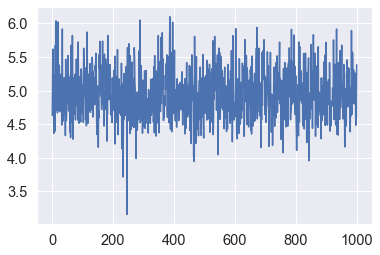

In [104]:
plt.plot(list_loss_multi)

### Eval

In [17]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1a46308e10> and <tensorflow.python.keras.layers.core.Dropout object at 0x1a46367990>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1a4637d250> and <tensorflow.python.keras.layers.core.Dense object at 0x1a46387810>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1a4637d250> and <tensorflow.python.keras.layers.core.Dropout object at 0x1a46367990>).
CPU times: user 2.27 s, sys: 245 ms, total: 2.51 s
Wall time: 2.74 s


In [18]:
%%time
y_val_multi_pred = multi_step_model.predict(x_val_multi)
data_std[4] * mean_absolute_error(y_val_multi, y_val_multi_pred)

CPU times: user 486 ms, sys: 45.3 ms, total: 532 ms
Wall time: 606 ms


954.7050423896358

In [19]:
multi_step_model.predict(x_val_multi)

array([[4.2362766, 1.9560788, 1.9163101, 4.0508265, 5.6723313, 5.6169596,
        6.7602015],
       [3.708486 , 1.2125471, 2.1054263, 5.5474424, 5.7975307, 6.194437 ,
        8.416377 ],
       [1.9769408, 4.9981837, 3.6789486, 3.9958367, 5.224452 , 5.1679626,
        2.367186 ],
       [4.4498577, 4.025905 , 3.6408353, 4.289071 , 4.4793515, 1.2842196,
        1.8120195],
       [5.387265 , 4.3540173, 5.638873 , 5.6407294, 1.4751705, 1.2166972,
        7.7178426],
       [5.231017 , 4.7427645, 3.6804159, 1.7937353, 2.781758 , 6.2916913,
        8.379879 ],
       [5.22118  , 3.304751 , 1.8073237, 1.2193329, 4.8715487, 8.309004 ,
        8.557323 ]], dtype=float32)

In [20]:
y_val_multi_pred.shape[0]

7

In [21]:
val_data_multi

<RepeatDataset shapes: ((None, 14, 9), (None, 7)), types: (tf.float64, tf.float64)>

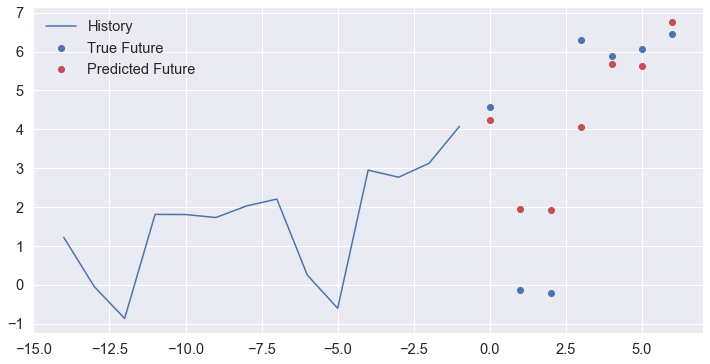

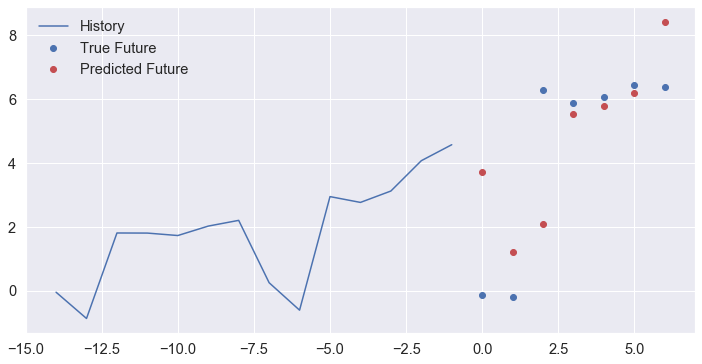

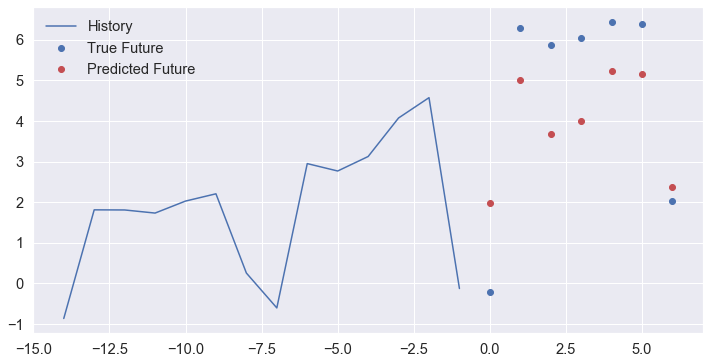

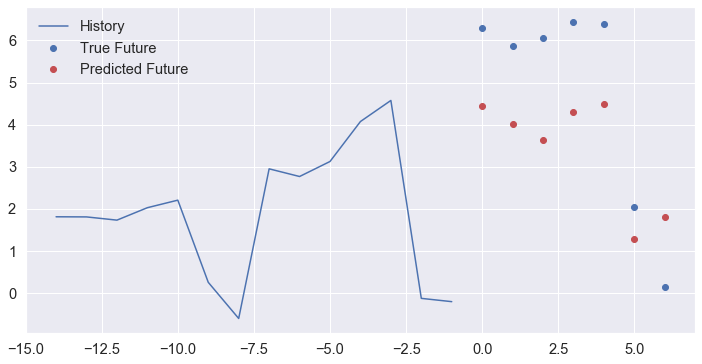

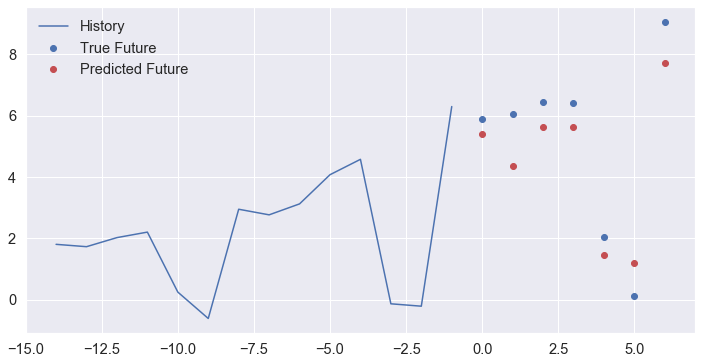

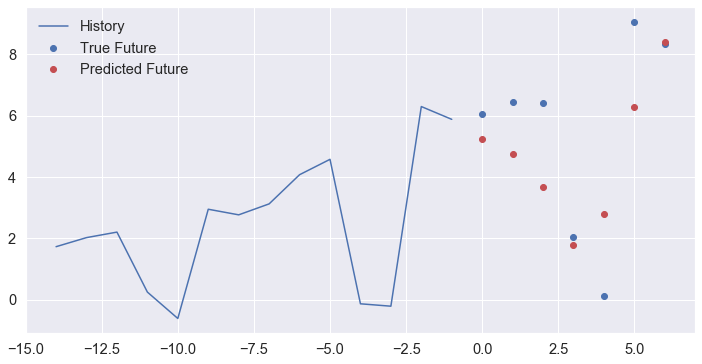

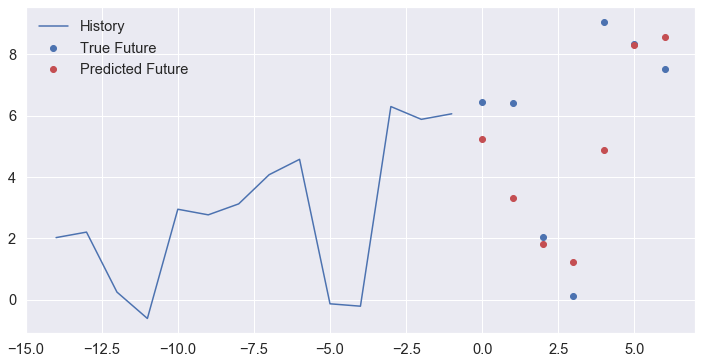

In [22]:
'''for x, y in val_data_single.take(1):
    for I in range(12):
        plot = show_plot([x[I][:, 4].numpy(), y[I].numpy(),
                        multi_step_model.predict(x)[I]], 3,
                       'Multi Step Prediction')
        plot.show()'''



for x, y in val_data_multi.take(1):
    for I in range(y_val_multi_pred.shape[0]):
        multi_step_plot(x[I], y[I], multi_step_model.predict(x)[I])

### Final Prediction

In [49]:
PATH_MDL_MULTI_STEP

'./mdl_multi_step_pos_fr'

In [23]:
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1a47c1fdd0> and <tensorflow.python.keras.layers.core.Dropout object at 0x1a47c28310>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1a47c28b10> and <tensorflow.python.keras.layers.core.Dense object at 0x1a47c2bfd0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1a47c28b10> and <tensorflow.python.keras.layers.core.Dropout object at 0x1a47c28310>).


In [104]:
# reload data
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]
# prepare features
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
# calculate mean & std 
#TRAIN_SPLIT = 93
# prepare dataset
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [105]:
%%time
# prepare data : very last days
x_multi = np.array([dataset[-PAST_HISTORY:,:]]) 
# predict next days
y_multi_pred = multi_step_model.predict(x_multi)
y_multi_pred

# convert in positive cases
y_pos_pred = y_multi_pred * data_std[4] + data_mean[4]


CPU times: user 50.6 ms, sys: 18.6 ms, total: 69.3 ms
Wall time: 95.2 ms


In [106]:
dataset[-PAST_HISTORY:,4] * data_std[4] + data_mean[4]

array([3790.,  719.,  668., 4912., 4640., 4758., 5008., 4979., 2131.,
        894., 6710., 6238., 5714., 5612.])

In [107]:
y_pos_pred

array([[4202.0654, 1616.9805, 1884.9954, 3970.4722, 5045.1743, 5785.105 ,
        7364.4663]], dtype=float32)

In [101]:
'''%%time
# prepare data : very last days
x_multi = np.array([dataset[-PAST_HISTORY-3*FUTURE_TARGET:-3*FUTURE_TARGET,:]]) 
# predict next days
y_multi_pred = multi_step_model.predict(x_multi)
y_multi_pred

# convert in positive cases
y_pos_pred = y_multi_pred * data_std[4] + data_mean[4]'''
#

'%%time\n# prepare data : very last days\nx_multi = np.array([dataset[-PAST_HISTORY-3*FUTURE_TARGET:-3*FUTURE_TARGET,:]]) \n# predict next days\ny_multi_pred = multi_step_model.predict(x_multi)\ny_multi_pred\n\n# convert in positive cases\ny_pos_pred = y_multi_pred * data_std[4] + data_mean[4]'

In [102]:
#dataset[-PAST_HISTORY-FUTURE_TARGET:,4] * data_std[4] + data_mean[4]

In [103]:
#y_pos_pred

In [108]:
df_feat_fr.date.max()

'2020-08-27'

In [109]:
df_feat_fr.pos.std()

1457.5636177802205

In [110]:
data_std[4]

653.277832168677

In [111]:
# last nth days

str_date_0 = add_days(df_feat_fr.date.max(), -NB_DAY_PLOT)
df_plot = df_feat_fr[df_feat_fr["date"] >= str_date_0].copy()

# add pos pred next days from last day : date, pos, total (sum)
str_date_pred_0 = df_feat_fr.date.max()
str_date_pred_1 = add_days(str_date_pred_0, FUTURE_TARGET)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
# figure 
df_plot_pred = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred["pos"] = y_pos_pred[0].astype(int)
arr_nb_pred = df_plot_pred["pos"].cumsum().values
df_plot_pred["nb_cases"] = df_plot["nb_cases"].max() + arr_nb_pred
    
df_plot_pred

,date,pos,nb_cases
2020-08-28,2020-08-28,4202,275745
2020-08-29,2020-08-29,1616,277361
2020-08-30,2020-08-30,1884,279245
2020-08-31,2020-08-31,3970,283215
2020-09-01,2020-09-01,5045,288260
2020-09-02,2020-09-02,5785,294045
2020-09-03,2020-09-03,7364,301409


In [112]:
df_feat_fr.iloc[TRAIN_SPLIT]["date"]

'2020-08-14'

In [113]:
df_plot

,date,T_min,T_max,H_min,H_max,pos,age_pos,test,age_test,day_num,nb_cases
date,,,,,,,,,,,
2020-06-25,2020-06-25,291.130000,300.748333,51.440678,83.915254,508,45.417323,36190,50.845344,4,163496
2020-06-26,2020-06-26,291.212712,298.170339,60.637931,89.275862,573,45.338569,47003,50.638215,5,164069
2020-06-27,2020-06-27,290.624138,297.472414,60.107143,90.464286,335,44.486567,22657,51.610187,6,164404
2020-06-28,2020-06-28,290.126667,296.203333,60.017241,88.603448,215,45.460465,7250,54.316966,0,164619
2020-06-29,2020-06-29,289.650000,296.024576,55.413793,88.379310,668,44.631737,55946,49.476477,1,165287
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-23,2020-08-23,290.191667,296.646667,52.758621,83.896552,894,40.429530,18404,46.070745,0,247269
2020-08-24,2020-08-24,288.921667,296.960000,51.491525,84.559322,6710,39.931148,155908,46.242226,1,253979
2020-08-25,2020-08-25,288.920000,298.748333,51.101695,85.220339,6238,39.625040,144712,46.254201,2,260217


In [114]:
#df_plot.iloc[TRAIN_SPLIT]["date"]

### Figure

In [115]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total cases"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total predicted"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="New cases"), 
             secondary_y=True)

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="New predicted"), 
            secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France with prediction</b><br>' + \
    'LMST Deep Learning Model : ' + \
    'prediction of <b>{} days</b>'.format(FUTURE_TARGET) + \
    ' from <b>last {} days</b>'.format(PAST_HISTORY) + \
    '<br>Trained until ' + df_feat_fr.iloc[TRAIN_SPLIT]["date"]

fig.update_layout(title=title_fig,
                   yaxis_title='nb confirmed cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))

fig.update_yaxes(title_text="daily cases", range=[0, 10000], secondary_y=True)

fig.show()


### Predict all past

In [116]:
%%time
# prepare list of past histories
list_x = []
# prepare data : very last days
nb_max = math.ceil((NB_DAY_PLOT)/FUTURE_TARGET)
I_start_pred = TRAIN_SPLIT - nb_max*FUTURE_TARGET
for I in range(nb_max):
    I_start = I_start_pred + I * FUTURE_TARGET - PAST_HISTORY
    I_end =   I_start_pred + I * FUTURE_TARGET
    print(f"[{I_start} - {I_end}]")
    list_x.append(np.array([dataset[I_start:I_end, :]]))
print(len(list_x))
# predict
for I, x_multi in enumerate(list_x):
    if I:
        y_multi_pred = np.concatenate([y_multi_pred, 
            multi_step_model.predict(x_multi)], axis=1)
    else:
        y_multi_pred = multi_step_model.predict(x_multi)   
# convert in positive cases
y_pos_pred = (y_multi_pred * data_std[4]) + data_mean[4] 
y_pos_pred

[16 - 30]
[23 - 37]
[30 - 44]
[37 - 51]
[44 - 58]
[51 - 65]
[58 - 72]
[65 - 79]
[72 - 86]
9
first...
CPU times: user 502 ms, sys: 166 ms, total: 668 ms
Wall time: 998 ms


array([[ 228.90747,  260.6999 ,  192.89246,  251.64368,  407.5002 ,
         550.63354,  433.49252,  275.61664,  246.80743,  234.82501,
         329.0535 ,  465.43442,  583.1065 ,  516.3274 ,  575.1732 ,
         407.5001 ,  386.74542,  481.81747,  650.0419 ,  590.202  ,
         573.7522 ,  559.7108 ,  415.22678,  318.52414,  467.68826,
         676.2623 ,  708.9585 ,  707.95337,  721.2918 ,  506.23566,
         443.41666,  569.1349 ,  789.12335,  836.3436 ,  910.41425,
         893.11084,  559.6542 ,  551.3323 ,  770.3429 , 1127.2177 ,
        1135.5156 , 1126.345  , 1247.1249 ,  886.09143,  839.19324,
        1104.5846 , 1606.988  , 1645.5667 , 1619.9384 , 1754.1782 ,
        1140.1223 , 1196.4962 , 1737.5111 , 2256.8716 , 2007.0967 ,
        2240.8313 , 2313.3667 , 1378.6418 , 1527.957  , 2561.0444 ,
        2982.093  , 2871.1528 , 3597.113  ]], dtype=float32)

In [122]:
K_days

63

In [160]:
# create df out prediction
K_days = y_pos_pred.shape[1]
str_date_pred_1 = df_feat_fr.date.max()
str_date_pred_0 = add_days(str_date_pred_1, -1*K_days)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
print(len(list_dates_pred))
print(str_date_pred_0)
print(str_date_pred_1)

df_plot_pred_all = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred_all["pos"] = y_pos_pred[0].astype(int)

list_nb_cases =[]
str_date_nb_0 = str_date_pred_0
for I in range(0, df_plot_pred_all["pos"].shape[0], FUTURE_TARGET):
    str_date_nb_0 = add_days(str_date_pred_0, I)
    nb_0 = df_feat_fr[df_feat_fr["date"] == str_date_nb_0]["nb_cases"][0]
    arr_nb = nb_0 + \
        df_plot_pred_all.iloc[I:I+FUTURE_TARGET]["pos"].cumsum().values
    list_nb_cases = list_nb_cases + arr_nb.tolist()
df_plot_pred_all["nb_cases"] = list_nb_cases


df_plot_pred_all

63
2020-06-25
2020-08-27


,date,pos,nb_cases
2020-06-26,2020-06-26,228,163724
2020-06-27,2020-06-27,260,163984
2020-06-28,2020-06-28,192,164176
2020-06-29,2020-06-29,251,164427
2020-06-30,2020-06-30,407,164834
...,...,...,...
2020-08-23,2020-08-23,1527,244483
2020-08-24,2020-08-24,2561,247044
2020-08-25,2020-08-25,2982,250026
2020-08-26,2020-08-26,2871,252897


In [149]:
add_days(str_date_pred_0, 0)

'2020-06-25'

In [150]:
str_date_pred_0

'2020-06-25'

In [156]:
df_plot_pred_all.iloc[I:I+FUTURE_TARGET]["pos"].cumsum().values +1

array([ 229,  489,  681,  932, 1339, 1889, 2322])

In [176]:
'''# create df out prediction
K_days = y_pos_pred.shape[1]
str_date_pred_1 = df_feat_fr.date.max()
str_date_pred_0 = add_days(str_date_pred_1, -1*K_days)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
print(len(list_dates_pred))
print(str_date_pred_0)
print(str_date_pred_1)

df_plot_pred_all = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred_all["pos"] = y_pos_pred[0].astype(int)
arr_nb_pred = df_plot_pred_all["pos"].cumsum().values
df_plot_pred_all["nb_cases"] = df_feat_fr[df_feat_fr["date"] == \
    str_date_pred_0]["nb_cases"][0] + arr_nb_pred


df_plot_pred_all'''

'# create df out prediction\nK_days = y_pos_pred.shape[1]\nstr_date_pred_1 = df_feat_fr.date.max()\nstr_date_pred_0 = add_days(str_date_pred_1, -1*K_days)\nlist_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)\nprint(len(list_dates_pred))\nprint(str_date_pred_0)\nprint(str_date_pred_1)\n\ndf_plot_pred_all = pd.DataFrame(index=list_dates_pred, columns=["date"], \n                       data=list_dates_pred)\n\ndf_plot_pred_all["pos"] = y_pos_pred[0].astype(int)\narr_nb_pred = df_plot_pred_all["pos"].cumsum().values\ndf_plot_pred_all["nb_cases"] = df_feat_fr[df_feat_fr["date"] ==     str_date_pred_0]["nb_cases"][0] + arr_nb_pred\n\n\ndf_plot_pred_all'

### Figure all past 

In [189]:
str_date_mdl =  df_feat_fr.iloc[TRAIN_SPLIT]["date"]

In [192]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Create and style traces
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.5), 
             secondary_y=True)
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    connectgaps=True, name="Total (estim.)"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    connectgaps=True, name="Total (future estim.)"),
             secondary_y=False)


fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.5), 
            secondary_y=True)

# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                range=[0, 10000], secondary_y=True)
    
fig.show()


In [119]:
df_plot_pred_all

,date,pos,nb_cases
2020-06-26,2020-06-26,228,164297
2020-06-27,2020-06-27,260,164557
2020-06-28,2020-06-28,192,164749
2020-06-29,2020-06-29,251,165000
2020-06-30,2020-06-30,407,165407
...,...,...,...
2020-08-23,2020-08-23,1527,213979
2020-08-24,2020-08-24,2561,216540
2020-08-25,2020-08-25,2982,219522
2020-08-26,2020-08-26,2871,222393


In [28]:
df_feat_fr[df_feat_fr["date"] == \
    df_plot_pred_all["date"].min()]["nb_cases"][0]

166593

### Convert model in TFlite

In [177]:
dataset.shape[1]

9

In [178]:
run_model = tf.function(lambda x: multi_step_model(x))
# This is important, let's fix the input size.
INPUT_SIZE = dataset.shape[1]
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([1, PAST_HISTORY, INPUT_SIZE],
                  multi_step_model.inputs[0].dtype))

# model directory.
MODEL_DIR = PATH_TO_SAVE_DATA + "/" + "keras_lstm"
multi_step_model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./keras_lstm/assets


### Save model TFlite

In [179]:
clean_file(PATH_MDL_MULTI_TFLITE_FILE)

File ./serverless/tensorflow-lite-on-aws-lambda/converted_model_20200901_16_42_27.tflite moved!


In [180]:
open(PATH_MDL_MULTI_TFLITE_FILE, "wb").write(tflite_model)

6104

### Predict with TFlite & Compare 

In [181]:
# load 
interpreter = tf.lite.Interpreter(model_content=tflite_model)

# Run the model with TensorFlow Lite
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# check if same results 
for x_multi in list_x:
    # predict with tensorflow model
    expected = multi_step_model.predict(x_multi)
    # predict with TFlite model
    interpreter.set_tensor(input_details[0]["index"], 
                           x_multi.astype(np.float32))
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])

    # Assert if the result of TFLite model is consistent with the TF model.
    np.testing.assert_almost_equal(expected, result)
    print("Done. The result of TensorFlow matches the result of TensorFlow Lite.")

    # Please note: TfLite fused Lstm kernel is stateful, so we need to reset
    # the states.
    # Clean up internal states.
    interpreter.reset_all_variables()

Done. The result of TensorFlow matches the result of TensorFlow Lite.


AssertionError: 
Arrays are not almost equal to 7 decimals

Mismatched elements: 1 / 7 (14.3%)
Max absolute difference: 1.7881393e-07
Max relative difference: 2.0612767e-07
 x: array([[-0.8050495, -0.849149 , -0.867491 , -0.7232515, -0.5144874,
        -0.3343618, -0.4365834]], dtype=float32)
 y: array([[-0.8050495, -0.849149 , -0.8674912, -0.7232516, -0.5144875,
        -0.3343619, -0.4365835]], dtype=float32)

### Reload Tlite model

In [182]:
interpreter = tf.lite.Interpreter(model_path=PATH_MDL_MULTI_TFLITE_FILE)

In [194]:
PATH_MDL_MULTI_TFLITE_FILE

'./serverless/tensorflow-lite-on-aws-lambda/converted_model.tflite'

### Predict reloaded model

In [183]:
# Run the model with TensorFlow Lite
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# check if same results 
for x_multi in list_x:
    
    expected = multi_step_model.predict(x_multi)
    
    interpreter.set_tensor(input_details[0]["index"], 
                           x_multi.astype(np.float32))
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])

    # Assert if the result of TFLite model is consistent with the TF model.
    np.testing.assert_almost_equal(expected, result)
    print("Done. The result of TensorFlow matches the result of TensorFlow Lite.")

    # Please note: TfLite fused Lstm kernel is stateful, so we need to reset
    # the states.
    # Clean up internal states.
    interpreter.reset_all_variables()

Done. The result of TensorFlow matches the result of TensorFlow Lite.


AssertionError: 
Arrays are not almost equal to 7 decimals

Mismatched elements: 1 / 7 (14.3%)
Max absolute difference: 1.7881393e-07
Max relative difference: 2.0612767e-07
 x: array([[-0.8050495, -0.849149 , -0.867491 , -0.7232515, -0.5144874,
        -0.3343618, -0.4365834]], dtype=float32)
 y: array([[-0.8050495, -0.849149 , -0.8674912, -0.7232516, -0.5144875,
        -0.3343619, -0.4365835]], dtype=float32)

In [184]:
x_multi.shape

(1, 14, 9)

In [185]:
len(list_x)

9

### API lambda simulate

In [36]:
dataset.shape

(100, 7)

In [193]:
def prepare_to_lambda(dataset):
    '''
    Prepare data input model to be used by lambda: 
    
    for prediction all past days
    '''
    list_list_x = []
    nb_max = math.ceil((NB_DAY_PLOT)/FUTURE_TARGET)
    I_start_pred = TRAIN_SPLIT - nb_max*FUTURE_TARGET
    for I in range(nb_max):
        I_start = I_start_pred + I * FUTURE_TARGET - PAST_HISTORY
        I_end =   I_start_pred + I * FUTURE_TARGET
        print(f"[{I_start} - {I_end}]")
        list_list_x.append(np.array([dataset[I_start:I_end, :]]).tolist())
        
    json_list_list_x = json.dumps(list_list_x)
    return json_list_list_x

json_list_list_x = prepare_to_lambda(dataset)
# simulate input to lambda (double dumps ? why ? i don't know yet)
json_list_list_x = json.dumps(json_list_list_x)
# simulate lambda

event = {"body": json_list_list_x}

[16 - 30]
[23 - 37]
[30 - 44]
[37 - 51]
[44 - 58]
[51 - 65]
[58 - 72]
[65 - 79]
[72 - 86]


In [195]:
# patch for simulate import in AWS
import tensorflow.lite as tflite

# lambda code
def predict(event, context):
    # retrieve entry event -> json_list_list_x
    json_list_list_x = event.get('body')
    print(json_list_list_x[0:50])
    list_list_in = json.loads(json.loads(json_list_list_x))
    # convert in list of array
    # retrieve json into lambda
    list_arr_in = []
    for list_curr in list_list_in:
        list_arr_in.append(np.array(list_curr))

    print("INPUT : nb. arrays : {} / arrays shape: {}".format(len(list_arr_in), 
                                             list_arr_in[0].shape))

    # prepare TFlite model
    interpreter = tflite.Interpreter(model_path=PATH_MDL_MULTI_TFLITE_FILE)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()


    # Run the model with TensorFlow Lite
    list_list_out = []
    for x_multi in list_arr_in:
        interpreter.set_tensor(input_details[0]["index"], 
                               x_multi.astype(np.float32))
        interpreter.invoke()
        result = interpreter.get_tensor(output_details[0]["index"])
        list_list_out.append(result.tolist())
        # Please note: TfLite fused Lstm kernel is stateful, so we need to reset
        # the states.
        # Clean up internal states.
        interpreter.reset_all_variables()
    print("OUTPUT : nb. arrays : {} / arrays shape in list: {}" \
          .format(len(list_list_out), np.array(list_list_out[0]).shape))

    # Prepare output
    json_list_list_out = json.dumps(list_list_out)
    response = {
        "statusCode": 200,
        "body": json_list_list_out
    }
    return response

context = None
response = predict(event, context)



"[[[[-0.4066992270159372, 0.018747776757483788, -1
INPUT : nb. arrays : 9 / arrays shape: (1, 14, 9)
OUTPUT : nb. arrays : 9 / arrays shape in list: (1, 7)


In [198]:
# Retrieve from lambda in App code
# input : response
def retrieve_from_lambda(response):
    if type(response)  == requests.models.Response:
        list_list_out = response.json()
    else: # for local test
        json_list_list_out = response.get("body")
        list_list_out = json.loads(json_list_list_out)
    
    y_multi_pred_out = []
    for I, list_x_multi in enumerate(list_list_out):
        if I:
            y_multi_pred_out = np.concatenate([y_multi_pred_out, 
                                           np.array(list_x_multi)],
                                  axis=1)
        else: # for first entry
            y_multi_pred_out = np.array(list_x_multi)
    return y_multi_pred_out
        
y_multi_pred_out = retrieve_from_lambda(response)      
y_multi_pred_out.shape

(1, 63)

In [199]:
y_multi_pred

array([[-0.87654924, -0.82788324, -0.93167895, -0.841746  , -0.6031698 ,
        -0.38406953, -0.56338227, -0.80504954, -0.849149  , -0.867491  ,
        -0.72325146, -0.51448745, -0.33436182, -0.43658343, -0.3465056 ,
        -0.60317   , -0.63494   , -0.4894092 , -0.23190105, -0.3235004 ,
        -0.34868088, -0.37017456, -0.5913424 , -0.7393692 , -0.5110374 ,
        -0.1917643 , -0.14171486, -0.14325348, -0.12283568, -0.45203125,
        -0.54819095, -0.3557488 , -0.01900306,  0.05327892,  0.16666201,
         0.14017493, -0.37026125, -0.38299996, -0.0477511 ,  0.49853212,
         0.51123416,  0.49719632,  0.6820792 ,  0.12943006,  0.05764098,
         0.4638868 ,  1.232937  ,  1.2919909 ,  1.2527605 ,  1.4582473 ,
         0.5182858 ,  0.6045798 ,  1.4327341 ,  2.2277412 ,  1.8454003 ,
         2.2031877 ,  2.3142207 ,  0.8833979 ,  1.1119608 ,  2.6933513 ,
         3.3378685 ,  3.1680474 ,  4.2793055 ]], dtype=float32)

In [200]:
y_multi_pred_out

array([[-0.87654924, -0.8278833 , -0.93167907, -0.84174597, -0.60316968,
        -0.38406944, -0.56338239, -0.80504954, -0.84914899, -0.86749119,
        -0.72325158, -0.5144875 , -0.33436188, -0.43658349, -0.34650561,
        -0.60317004, -0.63494003, -0.48940924, -0.23190114, -0.32350045,
        -0.34868082, -0.37017462, -0.59134233, -0.73936915, -0.51103747,
        -0.19176432, -0.1417148 , -0.14325351, -0.12283565, -0.45203125,
        -0.54819101, -0.35574883, -0.01900294,  0.05327904,  0.16666204,
         0.14017498, -0.37026125, -0.38299999, -0.04775111,  0.49853206,
         0.51123416,  0.49719629,  0.6820792 ,  0.1294302 ,  0.05764117,
         0.4638868 ,  1.23293674,  1.29199076,  1.25276065,  1.45824718,
         0.51828575,  0.60457969,  1.43273413,  2.227741  ,  1.84540033,
         2.2031877 ,  2.31422019,  0.88339835,  1.11196077,  2.69335079,
         3.33786774,  3.16804767,  4.27930593]])

In [201]:
# Prepare data to lambda (future)

def prepare_to_lambda_future(dataset):
    '''
    Prepare data input model to be used by lambda: 
    
    for prediction of very last days
    '''
    return json.dumps([[dataset[-PAST_HISTORY:,:].tolist()]])

json_list_list_x = prepare_to_lambda_future(dataset)

# simulate lambda
json_list_list_x = json.dumps(json_list_list_x) # dumps again : I dont know why
event = {"body": json_list_list_x}
context = None
response = predict(event, context)
y_future_pred_out = retrieve_from_lambda(response)      
y_future_pred_out.shape

"[[[[1.4354078109002673, 0.46843107442540527, 0.77
INPUT : nb. arrays : 1 / arrays shape: (1, 14, 9)
OUTPUT : nb. arrays : 1 / arrays shape in list: (1, 7)


(1, 7)

In [202]:
# prepare data : very last days
x_for_future = np.array([dataset[-PAST_HISTORY:,:]]) 
# predict next days
y_future_pred = multi_step_model.predict(x_for_future)

In [203]:
y_future_pred_out

array([[ 5.20533133,  1.24823296,  1.65849459,  4.85082197,  6.49591398,
         7.62855768, 10.04615211]])

In [204]:
y_future_pred

array([[ 5.2053313,  1.2482327,  1.6584944,  4.850822 ,  6.4959145,
         7.6285577, 10.046152 ]], dtype=float32)

### Update AWS Lambda with new model


Go to : ./serverless//tensorflow-lite-on-aws-lambda
    
Execute : sls deploy -v

In [205]:
str_exe = '#!/bin/bash\n' + \
    'export PATH="/usr/local/bin:$PATH"\n' + \
    f'cd {PATH_MDL_MULTI_TFLITE}\n' + \
    'serverless deploy -v'
str_exe

'#!/bin/bash\nexport PATH="/usr/local/bin:$PATH"\ncd ./serverless/tensorflow-lite-on-aws-lambda\nserverless deploy -v'

In [206]:
open('deploy_serverless.sh', "w").write(str_exe)
os.chmod('deploy_serverless.sh', stat.S_IRWXU)

In [207]:
!cat ./deploy_serverless.sh

#!/bin/bash
export PATH="/usr/local/bin:$PATH"
cd ./serverless/tensorflow-lite-on-aws-lambda
serverless deploy -v

In [208]:
!./deploy_serverless.sh

Serverless: Generated requirements from /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/serverless/tensorflow-lite-on-aws-lambda/requirements.txt in /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/serverless/tensorflow-lite-on-aws-lambda/.serverless/requirements.txt...
Serverless: Using static cache of requirements found at /Users/gregory/Library/Caches/serverless-python-requirements/ef4e42eb03bbad46f74fee99a3c01f994e8119e7a557f947779093ab37b248d3_slspyc ...
Serverless: Packaging service...
Serverless: Excluding development dependencies...
Serverless: Injecting required Python packages to package...
Serverless: Uploading CloudFormation file to S3...
Serverless: Uploading artifacts...
Serverless: Uploading service tensorflow-lite-on-aws-lambda.zip file to S3 (18.4 MB)...
Serverless: Validating template...
Serverless: Updating Stack...
Serverless: Checking Stack update progress...
CloudF

### API AWS real Test

In [209]:
# prepare input
json_list_list_x = prepare_to_lambda(dataset)
# REQUEST
resp = requests.post(URL_PREDICT, json=json_list_list_x)
print("status code : ", resp.status_code) 
print(resp.json())

[16 - 30]
[23 - 37]
[30 - 44]
[37 - 51]
[44 - 58]
[51 - 65]
[58 - 72]
[65 - 79]
[72 - 86]
status code :  200
[[[-0.876549243927002, -0.827883243560791, -0.9316790103912354, -0.8417460322380066, -0.6031697988510132, -0.3840695023536682, -0.5633823871612549]], [[-0.8050494194030762, -0.8491489887237549, -0.8674910068511963, -0.7232515215873718, -0.5144874453544617, -0.33436182141304016, -0.43658336997032166]], [[-0.3465055823326111, -0.6031699776649475, -0.6349400281906128, -0.4894092381000519, -0.23190104961395264, -0.3235003352165222, -0.34868088364601135]], [[-0.3701745271682739, -0.5913422703742981, -0.7393690943717957, -0.5110374689102173, -0.19176429510116577, -0.14171476662158966, -0.14325344562530518]], [[-0.12283570319414139, -0.4520312547683716, -0.5481908917427063, -0.3557488024234772, -0.019003059715032578, 0.05327893793582916, 0.16666199266910553]], [[0.1401749849319458, -0.37026137113571167, -0.382999986410141, -0.04775106534361839, 0.49853214621543884, 0.5112342238426208, 

In [210]:
len(json_list_list_x)

23726

In [211]:
resp.json()

[[[-0.876549243927002,
   -0.827883243560791,
   -0.9316790103912354,
   -0.8417460322380066,
   -0.6031697988510132,
   -0.3840695023536682,
   -0.5633823871612549]],
 [[-0.8050494194030762,
   -0.8491489887237549,
   -0.8674910068511963,
   -0.7232515215873718,
   -0.5144874453544617,
   -0.33436182141304016,
   -0.43658336997032166]],
 [[-0.3465055823326111,
   -0.6031699776649475,
   -0.6349400281906128,
   -0.4894092381000519,
   -0.23190104961395264,
   -0.3235003352165222,
   -0.34868088364601135]],
 [[-0.3701745271682739,
   -0.5913422703742981,
   -0.7393690943717957,
   -0.5110374689102173,
   -0.19176429510116577,
   -0.14171476662158966,
   -0.14325344562530518]],
 [[-0.12283570319414139,
   -0.4520312547683716,
   -0.5481908917427063,
   -0.3557488024234772,
   -0.019003059715032578,
   0.05327893793582916,
   0.16666199266910553]],
 [[0.1401749849319458,
   -0.37026137113571167,
   -0.382999986410141,
   -0.04775106534361839,
   0.49853214621543884,
   0.5112342238426208,

In [212]:
y_multi_pred_out = retrieve_from_lambda(resp)      
y_multi_pred_out.shape

(1, 63)

In [213]:
y_multi_pred_out

array([[-0.87654924, -0.82788324, -0.93167901, -0.84174603, -0.6031698 ,
        -0.3840695 , -0.56338239, -0.80504942, -0.84914899, -0.86749101,
        -0.72325152, -0.51448745, -0.33436182, -0.43658337, -0.34650558,
        -0.60316998, -0.63494003, -0.48940924, -0.23190105, -0.32350034,
        -0.34868088, -0.37017453, -0.59134227, -0.73936909, -0.51103747,
        -0.1917643 , -0.14171477, -0.14325345, -0.1228357 , -0.45203125,
        -0.54819089, -0.3557488 , -0.01900306,  0.05327894,  0.16666199,
         0.14017498, -0.37026137, -0.38299999, -0.04775107,  0.49853215,
         0.51123422,  0.49719638,  0.6820792 ,  0.12943   ,  0.05764097,
         0.4638868 ,  1.23293698,  1.29199076,  1.25276053,  1.4582473 ,
         0.51828581,  0.60457981,  1.43273425,  2.22774124,  1.84540033,
         2.2031877 ,  2.31422067,  0.88339829,  1.11196125,  2.69335175,
         3.33786798,  3.16804743,  4.27930593]])

In [214]:
y_multi_pred

array([[-0.87654924, -0.82788324, -0.93167895, -0.841746  , -0.6031698 ,
        -0.38406953, -0.56338227, -0.80504954, -0.849149  , -0.867491  ,
        -0.72325146, -0.51448745, -0.33436182, -0.43658343, -0.3465056 ,
        -0.60317   , -0.63494   , -0.4894092 , -0.23190105, -0.3235004 ,
        -0.34868088, -0.37017456, -0.5913424 , -0.7393692 , -0.5110374 ,
        -0.1917643 , -0.14171486, -0.14325348, -0.12283568, -0.45203125,
        -0.54819095, -0.3557488 , -0.01900306,  0.05327892,  0.16666201,
         0.14017493, -0.37026125, -0.38299996, -0.0477511 ,  0.49853212,
         0.51123416,  0.49719632,  0.6820792 ,  0.12943006,  0.05764098,
         0.4638868 ,  1.232937  ,  1.2919909 ,  1.2527605 ,  1.4582473 ,
         0.5182858 ,  0.6045798 ,  1.4327341 ,  2.2277412 ,  1.8454003 ,
         2.2031877 ,  2.3142207 ,  0.8833979 ,  1.1119608 ,  2.6933513 ,
         3.3378685 ,  3.1680474 ,  4.2793055 ]], dtype=float32)

In [215]:
# prepare input
json_list_list_x = prepare_to_lambda_future(dataset)
# REQUEST URL_PREDICT = 'https://yl0910jrga.execute-api.us-east-2.amazonaws.com/dev/infer' 
resp = requests.post(URL_PREDICT, json=json_list_list_x)
print("status code : ", resp.status_code) 
print(resp.json())

status code :  200
[[[5.205331325531006, 1.2482327222824097, 1.6584943532943726, 4.8508219718933105, 6.495914459228516, 7.628557205200195, 10.046152114868164]]]


In [216]:
y_future_pred_out = retrieve_from_lambda(resp)      
y_future_pred_out

array([[ 5.20533133,  1.24823272,  1.65849435,  4.85082197,  6.49591446,
         7.62855721, 10.04615211]])

In [217]:
y_future_pred

array([[ 5.2053313,  1.2482327,  1.6584944,  4.850822 ,  6.4959145,
         7.6285577, 10.046152 ]], dtype=float32)